# (1.) Simple GAN สร้างภาพข้อมูล Fashion

สร้าง GAN อย่างง่าย ทำหน้าที่สร้างภาพข้อมูล Fashion MNIST มีภาพเสื้อผ้า 10 คลาส ทุกภาพขนาด 28x28 Pixel

## เตรียมความพร้อม

ตั้งค่า ให้รัน GPU ตรวจสอบสถานะ แล้วอิมพอร์ต

In [ ]:
!nvidia-smi

Wed Jan  3 08:39:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

from keras.datasets.fashion_mnist import load_data  # สำหรับโหลด Dataset
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Reshape, Dropout, Input

ตั้งค่าต่างๆ

In [ ]:
noise_dim = 100   # ขนาด (dimension) Random Vector ที่จะส่งเข้า Generator
batch_size = 64     # ขนาด batch size (ส่งภาพเข้าประมวลผล batch ละกี่ภาพ)

epochs = 10
# ขนาดภาพ และ channel ในที่นี้คือ 28x28x1 สี (ภาพโทนเทา)
img_rows, img_cols, channels = 28, 28, 1
optimizer = Adam(0.0002, 0.5)   # ค่าพารามิเตอร์สำหรับ optimizer
np.random.seed(10)    # กำหนดค่าสุ่ม ให้สุ่มได้เหมือนเดิม

## เตรียมข้อมูล

สำหรับ GAN นั้น จะไม่ได้ใช้ Label หรือ Class ของข้อมูลแต่อย่างใด สนใจแค่ข้อมูลที่ภาพ เพื่อไป Train เปรียบเทียบเท่านั้น แต่ถ้าเราโหลดมาทุกคลาส จะใช้เวลาในการประมวลผลนาน จึงขอลัดเอาแค่ 3 คลาสมาใช้ จึงเอา x_train, y_train (กรองเอาคลาสที่ต้องการ) (_ คือไม่สนใจ)

In [ ]:
(x_train, y_train), (_, _) = load_data()

โหลดเสร็จแล้วทำ Normalize เปลี่ยนข้อมูลภาพ 0-255 ให้เป็น -1 ถึง 1 (สามารถ Normalize ให้เป็น 0 - 1 ก็ได้) แล้วปรับ Reshape ให้มีมิติ Channel ด้วย เพื่อส่งเข้า CNN

In [ ]:
x_train = (x_train.astype(np.float32) - 127.5) / 127.5    # Normalize -1 to 1
print(x_train.shape)    # มิติต้นฉบับ

x_train = np.expand_dims(x_train, axis=-1)    # Reshape ให้มีมิติ Channel
print(x_train.shape)    # มิติที่ Reshape แล้ว
print('min max:', np.min(x_train), np.max(x_train))   # ค่า min max หลัง normalize

(60000, 28, 28)
(60000, 28, 28, 1)
min max: -1.0 1.0


ลดจำนวน Sample และจำนวนคลาสลง ในที่นี้ใช้ 6000 ภาพ/คลาส 3 คลาส เอาเฉพาะคลาส 0 1 2

In [ ]:
n_samples = 6000
x_train = x_train[np.where(y_train <= 2)[0]][:n_samples]    # กรองคลาสและจำนวน
x_train.shape

(6000, 28, 28, 1)

คำนวณหาจำนวนรอบ Iteration (จำนวน steps ต่อ epoch) ที่ใช้ Train = จำนวนข้อมูล / batch_size

In [ ]:
steps_per_epoch = math.ceil(n_samples / batch_size)
print(' number of batches:', steps_per_epoch)

 number of batches: 94


พล็อตดูข้อมูลบางส่วน

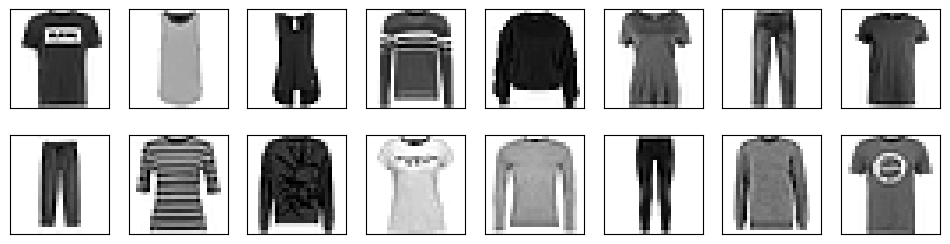

In [ ]:
def visual_multi(i):
  """Plots 15 digits, starting with digit i"""
  nplots = 16
  fig = plt.figure(figsize=(12, 3))   # 6x6
  for j in range(nplots):
    plt.subplot(2, 8, j+1)
    plt.imshow(np.squeeze(x_train[i+j]), cmap=plt.cm.gray_r)
    plt.xticks([]); plt.yticks([])
  plt.show()
visual_multi(0)

## สร้าง Model

GAN ต้องมี Generator และ Discriminator นำ 2 ส่วนนี้มาประกอบกัน โดย layer สุดท้าย (Output) จะต้องได้ข้อมูลหรือภาพที่มีมิติเท่ากับภาพของชุด Dataset เพราต้องนำไปเปรียบเทียบกัน

In [ ]:
# ฟังก์ชันสร้าง Model Generator
def create_generator():
  generator = Sequential()

  d = 7   # ขนาด dimension ฐาน เพื่อขยายต่อ
  generator.add(Dense(d*d*128, input_dim=noise_dim))
  generator.add(LeakyReLU(0.2))   #
  generator.add(Reshape((d, d, 128)))

  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same'))
  generator.add(LeakyReLU(0.2))   #

  generator.add(Conv2DTranspose(64, (4, 4), strides=2, padding='same'))
  generator.add(LeakyReLU(0.2))   #

  # ใช้ activation tanh เนื่องจากค่า Pixel มีข้อมูลระหว่าง -1 ถึง 1
  generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh'))

  generator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return generator

สำหรับตัว Discriminator ตัวอินพุตที่รับเข้า ต้องมี shape เป็น WxHxChannel โดยภาพจาก Dataset ถือเป็น Real Data ส่วนภาพจาก Generator เป็น Fake Data ดังนั้น output มีเพียง 1 Node เท่านั้น ใช้ sigmoid เพื่อให้ได้ 0 (Fake) หรือ 1 (Real)

In [ ]:
# ฟังก์ชันสร้าง Model Discriminator
def create_discriminator():
  discriminator = Sequential()

  discriminator.add(Conv2D(64, (3, 3), padding='same',
                           input_shape=(img_cols, img_rows, channels)))
  discriminator.add(LeakyReLU(0.2))   #

  discriminator.add(Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
  discriminator.add(LeakyReLU(0.2))   #

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid'))   # Output ของ discriminator

  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return discriminator

ต่อไป สร้าง Model จริง
- เรียกฟังก์ชันสร้าง Model Discriminator และ Model Generator
- Generator สร้างภาพปลอมขึ้นมา (fake_image) โดยใช้อินพุต Random noise
- ภาพปลอมถูกส่งเข้า Discrimanitor เพื่อตรวจว่าเหมือนจริงหรือเปล่า
- ช่วงระหว่าง Train GAN จะปิด (Freeze) ไม่ให้มีการ Train Discriminator เพราะจะ Train แยกต่างหาก เท่ากับว่าช่วง Train GAN มีเพียงส่วน Generator เท่านั้นที่ถูก Train

In [ ]:
# ประกอบร่าง GAN
discriminator = create_discriminator()    # สร้าง Model Discriminator
discriminator.trainable = False   # ปิดการ Train Discriminator

generator = create_generator()    # สร้าง Model Generator

gan_input = Input(shape=(noise_dim,))   # มิติอินพุต GAN คือมิติ Noise
fake_image = generator(gan_input)   # เอาต์พุต GAN คือผลลัพธ์จาก Generator
gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)   # สร้าง GAN
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

ดูสรุปรวม

In [ ]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 64)        131136    
 Transpose)                                           

In [ ]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 28, 28, 64)        0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 56, 56, 128)       73856     
 Transpose)                                                      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 56, 56, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 401408)            0         
                                                                 
 dropout_2 (Dropout)         (None, 401408)            0         
                                                      

In [ ]:
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         1027457   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 475905    
                                                                 
Total params: 1503362 (5.73 MB)
Trainable params: 1027457 (3.92 MB)
Non-trainable params: 475905 (1.82 MB)
_________________________________________________________________


Model Generator สร้างข้อมูลให้เหมือนจริงมากที่สุด โดยอินพุตคือ Noise (Noise -> Generator -> ภาพ image) ก่อน Train ลองพล็อตดูภาพปลอมจาก Generator ก่อน

1/1 [==============================] - 0s 82ms/step


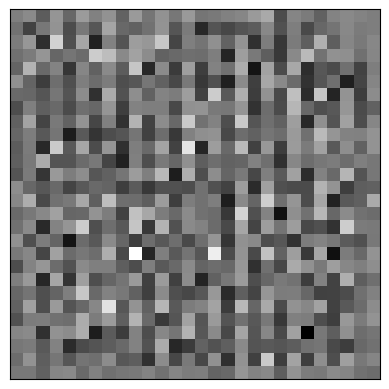

In [ ]:
noise = np.random.normal(0, 1, size=(1, noise_dim))     # สร้างค่า random (มิติ 100)
image = generator.predict(noise)   # Generator สร้างภาพ image จาก noise
plt.xticks([]); plt.yticks([])
plt.imshow(image.reshape((img_rows, img_cols)), cmap=plt.cm.gray_r)   # พล็อต
plt.show()

ก่อนการ Train ตัว Generator ยังไม่มีความรู้ใดๆ ภาพที่สร้างจึงดูสะเปะสะปะ ห่างไกลกับของจริงมาก

## Train

เพื่อให้เห็นภาพที่ได้จากการ Generator (ภาพ fake) ในแต่ละ Epoch ที่กำลัง Train ทำการสร้างฟังก์ชันพล็อตดูภาพ fake ดังนี้

In [ ]:
# พล็อตภาพ
def show_images(noise, size_fig):
  generated_images = generator.predict(noise)   # สร้างภาพ Fake
  plt.figure(figsize=(size_fig[1], size_fig[0]))

  for i, image in enumerate(generated_images):
    plt.subplot(size_fig[0], size_fig[1], i+1)
    if channels == 1:
      plt.imshow(image.reshape((img_rows, img_cols)), cmap=plt.cm.gray_r)
    else:
      plt.imshow(image.reshape((img_rows, img_cols, channels)))
    plt.axis('off')

  plt.tight_layout()
  plt.show()

การ Train มี 2 ส่วนคือ 1) Train Generator และ 2) Discriminator ถูกแยก Train ต่างหาก

ในช่วง Train Generator ค่า X หรืออิพุตคือค่าสุ่ม Noise ค่า y จะกำหนดเป็น 1 เสมอ เพื่อพยายามหลอกให้ Discriminator ตีความว่าเป็นของจริง

Train Discriminator อินพุตจะมี 2 ส่วนดังนี้
- กรณีข้อมูลภาพที่นำมาจาก Dataset จริง (x_train) ค่า y หรือ Label คลาส จะเข้าใกล้ 1 คือสอน Model ประมาณว่า "ข้อมูลจริง คลาสคือ 1 (Real)"
- กรณีข้อมูลภาพที่มาจาก Generator จริง (fake) ค่า y จะเป็น 0 คือสอน Model ประมาณว่า "ข้อมูล fake คลาสคือ 0 (Fake)"

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  1%|          | 1/94 [00:02<03:12,  2.07s/it]

2/2 [==============================] - 0s 5ms/step


  2%|▏         | 2/94 [00:02<01:52,  1.23s/it]

2/2 [==============================] - 0s 4ms/step


  3%|▎         | 3/94 [00:03<01:26,  1.05it/s]

2/2 [==============================] - 0s 4ms/step


  4%|▍         | 4/94 [00:03<01:13,  1.22it/s]

2/2 [==============================] - 0s 5ms/step


  5%|▌         | 5/94 [00:04<01:07,  1.32it/s]

2/2 [==============================] - 0s 5ms/step


  6%|▋         | 6/94 [00:05<01:02,  1.41it/s]

2/2 [==============================] - 0s 5ms/step


  7%|▋         | 7/94 [00:05<00:59,  1.47it/s]

2/2 [==============================] - 0s 7ms/step


  9%|▊         | 8/94 [00:06<00:56,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 10%|▉         | 9/94 [00:07<00:55,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 11%|█         | 10/94 [00:07<00:53,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 12%|█▏        | 11/94 [00:08<00:52,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 13%|█▎        | 12/94 [00:08<00:51,  1.59it/s]

2/2 [==============================] - 0s 4ms/step


 14%|█▍        | 13/94 [00:09<00:57,  1.42it/s]

2/2 [==============================] - 0s 6ms/step


 15%|█▍        | 14/94 [00:10<01:00,  1.32it/s]

2/2 [==============================] - 0s 4ms/step


 16%|█▌        | 15/94 [00:11<01:03,  1.24it/s]

2/2 [==============================] - 0s 5ms/step


 17%|█▋        | 16/94 [00:12<00:59,  1.31it/s]

2/2 [==============================] - 0s 5ms/step


 18%|█▊        | 17/94 [00:12<00:55,  1.39it/s]

2/2 [==============================] - 0s 5ms/step


 19%|█▉        | 18/94 [00:13<00:52,  1.45it/s]

2/2 [==============================] - 0s 5ms/step


 20%|██        | 19/94 [00:15<01:11,  1.05it/s]

2/2 [==============================] - 0s 5ms/step


 21%|██▏       | 20/94 [00:15<01:03,  1.17it/s]

2/2 [==============================] - 0s 5ms/step


 22%|██▏       | 21/94 [00:16<00:57,  1.28it/s]

2/2 [==============================] - 0s 5ms/step


 23%|██▎       | 22/94 [00:16<00:53,  1.35it/s]

2/2 [==============================] - 0s 5ms/step


 24%|██▍       | 23/94 [00:17<00:50,  1.41it/s]

2/2 [==============================] - 0s 5ms/step


 26%|██▌       | 24/94 [00:18<00:47,  1.47it/s]

2/2 [==============================] - 0s 5ms/step


 27%|██▋       | 25/94 [00:18<00:45,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 28%|██▊       | 26/94 [00:19<00:44,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 29%|██▊       | 27/94 [00:20<00:42,  1.57it/s]

2/2 [==============================] - 0s 6ms/step


 30%|██▉       | 28/94 [00:20<00:41,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 31%|███       | 29/94 [00:21<00:40,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 32%|███▏      | 30/94 [00:22<00:42,  1.51it/s]

2/2 [==============================] - 0s 7ms/step


 33%|███▎      | 31/94 [00:22<00:45,  1.38it/s]

2/2 [==============================] - 0s 4ms/step


 34%|███▍      | 32/94 [00:23<00:48,  1.28it/s]

2/2 [==============================] - 0s 4ms/step


 35%|███▌      | 33/94 [00:24<00:52,  1.17it/s]

2/2 [==============================] - 0s 5ms/step


 36%|███▌      | 34/94 [00:25<00:47,  1.27it/s]

2/2 [==============================] - 0s 5ms/step


 37%|███▋      | 35/94 [00:26<00:43,  1.36it/s]

2/2 [==============================] - 0s 4ms/step


 38%|███▊      | 36/94 [00:26<00:40,  1.43it/s]

2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 37/94 [00:27<00:48,  1.17it/s]

2/2 [==============================] - 0s 7ms/step


 40%|████      | 38/94 [00:29<00:52,  1.06it/s]

2/2 [==============================] - 0s 8ms/step


 41%|████▏     | 39/94 [00:30<00:55,  1.00s/it]

2/2 [==============================] - 0s 5ms/step


 43%|████▎     | 40/94 [00:30<00:48,  1.12it/s]

2/2 [==============================] - 0s 5ms/step


 44%|████▎     | 41/94 [00:31<00:45,  1.17it/s]

2/2 [==============================] - 0s 10ms/step


 45%|████▍     | 42/94 [00:32<00:47,  1.09it/s]

2/2 [==============================] - 0s 5ms/step


 46%|████▌     | 43/94 [00:33<00:45,  1.12it/s]

2/2 [==============================] - 0s 7ms/step


 47%|████▋     | 44/94 [00:34<00:45,  1.10it/s]

2/2 [==============================] - 0s 25ms/step


 48%|████▊     | 45/94 [00:35<00:49,  1.01s/it]

2/2 [==============================] - 0s 4ms/step


 49%|████▉     | 46/94 [00:36<00:51,  1.07s/it]

2/2 [==============================] - 0s 7ms/step


 50%|█████     | 47/94 [00:38<00:51,  1.09s/it]

2/2 [==============================] - 0s 9ms/step


 51%|█████     | 48/94 [00:38<00:46,  1.02s/it]

2/2 [==============================] - 0s 5ms/step


 52%|█████▏    | 49/94 [00:39<00:40,  1.11it/s]

2/2 [==============================] - 0s 7ms/step


 53%|█████▎    | 50/94 [00:40<00:35,  1.23it/s]

2/2 [==============================] - 0s 5ms/step


 54%|█████▍    | 51/94 [00:40<00:34,  1.24it/s]

2/2 [==============================] - 0s 5ms/step


 55%|█████▌    | 52/94 [00:41<00:35,  1.18it/s]

2/2 [==============================] - 0s 5ms/step


 56%|█████▋    | 53/94 [00:42<00:34,  1.18it/s]

2/2 [==============================] - 0s 13ms/step


 57%|█████▋    | 54/94 [00:43<00:35,  1.14it/s]

2/2 [==============================] - 0s 9ms/step


 59%|█████▊    | 55/94 [00:44<00:35,  1.09it/s]

2/2 [==============================] - 0s 5ms/step


 60%|█████▉    | 56/94 [00:45<00:32,  1.17it/s]

2/2 [==============================] - 0s 5ms/step


 61%|██████    | 57/94 [00:46<00:36,  1.01it/s]

2/2 [==============================] - 0s 4ms/step


 62%|██████▏   | 58/94 [00:47<00:32,  1.11it/s]

2/2 [==============================] - 0s 8ms/step


 63%|██████▎   | 59/94 [00:48<00:33,  1.04it/s]

2/2 [==============================] - 0s 12ms/step


 64%|██████▍   | 60/94 [00:50<00:38,  1.14s/it]

2/2 [==============================] - 0s 5ms/step


 65%|██████▍   | 61/94 [00:50<00:33,  1.02s/it]

2/2 [==============================] - 0s 5ms/step


 66%|██████▌   | 62/94 [00:51<00:28,  1.11it/s]

2/2 [==============================] - 0s 10ms/step


 67%|██████▋   | 63/94 [00:52<00:27,  1.12it/s]

2/2 [==============================] - 0s 9ms/step


 68%|██████▊   | 64/94 [00:53<00:27,  1.09it/s]

2/2 [==============================] - 0s 5ms/step


 69%|██████▉   | 65/94 [00:53<00:24,  1.18it/s]

2/2 [==============================] - 0s 4ms/step


 70%|███████   | 66/94 [00:55<00:26,  1.06it/s]

2/2 [==============================] - 0s 6ms/step


 71%|███████▏  | 67/94 [00:55<00:24,  1.11it/s]

2/2 [==============================] - 0s 6ms/step


 72%|███████▏  | 68/94 [00:56<00:22,  1.17it/s]

2/2 [==============================] - 0s 6ms/step


 73%|███████▎  | 69/94 [00:57<00:20,  1.22it/s]

2/2 [==============================] - 0s 5ms/step


 74%|███████▍  | 70/94 [00:58<00:19,  1.21it/s]

2/2 [==============================] - 0s 5ms/step


 76%|███████▌  | 71/94 [00:58<00:18,  1.25it/s]

2/2 [==============================] - 0s 8ms/step


 77%|███████▋  | 72/94 [01:00<00:19,  1.15it/s]

2/2 [==============================] - 0s 6ms/step


 78%|███████▊  | 73/94 [01:00<00:17,  1.18it/s]

2/2 [==============================] - 0s 5ms/step


 79%|███████▊  | 74/94 [01:01<00:17,  1.15it/s]

2/2 [==============================] - 0s 4ms/step


 80%|███████▉  | 75/94 [01:02<00:16,  1.14it/s]

2/2 [==============================] - 0s 8ms/step


 81%|████████  | 76/94 [01:03<00:15,  1.18it/s]

2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 77/94 [01:04<00:13,  1.29it/s]

2/2 [==============================] - 0s 7ms/step


 83%|████████▎ | 78/94 [01:04<00:11,  1.37it/s]

2/2 [==============================] - 0s 4ms/step


 84%|████████▍ | 79/94 [01:05<00:10,  1.44it/s]

2/2 [==============================] - 0s 5ms/step


 85%|████████▌ | 80/94 [01:05<00:09,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 81/94 [01:06<00:08,  1.53it/s]

2/2 [==============================] - 0s 5ms/step


 87%|████████▋ | 82/94 [01:07<00:07,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 88%|████████▊ | 83/94 [01:07<00:07,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 89%|████████▉ | 84/94 [01:08<00:06,  1.59it/s]

2/2 [==============================] - 0s 4ms/step


 90%|█████████ | 85/94 [01:08<00:05,  1.61it/s]

2/2 [==============================] - 0s 5ms/step


 91%|█████████▏| 86/94 [01:09<00:04,  1.61it/s]

2/2 [==============================] - 0s 5ms/step


 93%|█████████▎| 87/94 [01:10<00:04,  1.47it/s]

2/2 [==============================] - 0s 9ms/step


 94%|█████████▎| 88/94 [01:11<00:04,  1.36it/s]

2/2 [==============================] - 0s 5ms/step


 95%|█████████▍| 89/94 [01:12<00:04,  1.22it/s]

2/2 [==============================] - 0s 9ms/step


 96%|█████████▌| 90/94 [01:13<00:03,  1.05it/s]

2/2 [==============================] - 0s 18ms/step


 97%|█████████▋| 91/94 [01:15<00:03,  1.22s/it]

2/2 [==============================] - 0s 16ms/step


 98%|█████████▊| 92/94 [01:16<00:02,  1.20s/it]

2/2 [==============================] - 0s 4ms/step


 99%|█████████▉| 93/94 [01:17<00:01,  1.04s/it]

2/2 [==============================] - 0s 9ms/step


100%|██████████| 94/94 [01:18<00:00,  1.20it/s]

Epoch: 1/10 	 Discriminator Loss: 0.770 Generator Loss: 0.770
1/1 [==============================] - 0s 31ms/step


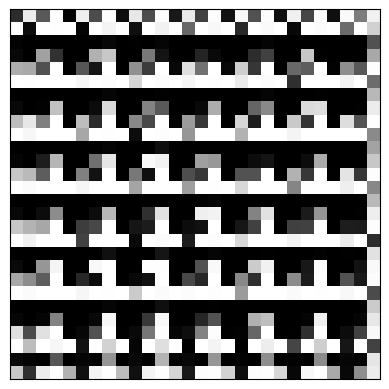

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


  1%|          | 1/94 [00:01<02:08,  1.38s/it]

2/2 [==============================] - 0s 7ms/step


  2%|▏         | 2/94 [00:02<01:54,  1.25s/it]

2/2 [==============================] - 0s 8ms/step


  3%|▎         | 3/94 [00:03<01:34,  1.04s/it]

2/2 [==============================] - 0s 4ms/step


  4%|▍         | 4/94 [00:03<01:18,  1.15it/s]

2/2 [==============================] - 0s 6ms/step


  5%|▌         | 5/94 [00:04<01:09,  1.28it/s]

2/2 [==============================] - 0s 4ms/step


  6%|▋         | 6/94 [00:05<01:04,  1.36it/s]

2/2 [==============================] - 0s 4ms/step


  7%|▋         | 7/94 [00:05<01:01,  1.42it/s]

2/2 [==============================] - 0s 5ms/step


  9%|▊         | 8/94 [00:06<00:58,  1.47it/s]

2/2 [==============================] - 0s 5ms/step


 10%|▉         | 9/94 [00:07<00:55,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 11%|█         | 10/94 [00:07<00:53,  1.56it/s]

2/2 [==============================] - 0s 9ms/step


 12%|█▏        | 11/94 [00:08<00:59,  1.41it/s]

2/2 [==============================] - 0s 4ms/step


 13%|█▎        | 12/94 [00:09<01:02,  1.31it/s]

2/2 [==============================] - 0s 4ms/step


 14%|█▍        | 13/94 [00:10<01:05,  1.23it/s]

2/2 [==============================] - 0s 5ms/step


 15%|█▍        | 14/94 [00:11<01:01,  1.30it/s]

2/2 [==============================] - 0s 4ms/step


 16%|█▌        | 15/94 [00:12<01:23,  1.05s/it]

2/2 [==============================] - 0s 4ms/step


 17%|█▋        | 16/94 [00:13<01:12,  1.08it/s]

2/2 [==============================] - 0s 5ms/step


 18%|█▊        | 17/94 [00:14<01:04,  1.19it/s]

2/2 [==============================] - 0s 5ms/step


 19%|█▉        | 18/94 [00:14<00:58,  1.30it/s]

2/2 [==============================] - 0s 5ms/step


 20%|██        | 19/94 [00:15<00:54,  1.38it/s]

2/2 [==============================] - 0s 5ms/step


 21%|██▏       | 20/94 [00:15<00:51,  1.44it/s]

2/2 [==============================] - 0s 5ms/step


 22%|██▏       | 21/94 [00:16<00:49,  1.48it/s]

2/2 [==============================] - 0s 4ms/step


 23%|██▎       | 22/94 [00:17<00:47,  1.51it/s]

2/2 [==============================] - 0s 4ms/step


 24%|██▍       | 23/94 [00:17<00:46,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 26%|██▌       | 24/94 [00:18<00:45,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 27%|██▋       | 25/94 [00:18<00:43,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 28%|██▊       | 26/94 [00:19<00:43,  1.58it/s]

2/2 [==============================] - 0s 4ms/step


 29%|██▊       | 27/94 [00:20<00:42,  1.59it/s]

2/2 [==============================] - 0s 4ms/step


 30%|██▉       | 28/94 [00:21<00:45,  1.46it/s]

2/2 [==============================] - 0s 4ms/step


 31%|███       | 29/94 [00:21<00:48,  1.35it/s]

2/2 [==============================] - 0s 4ms/step


 32%|███▏      | 30/94 [00:22<00:50,  1.26it/s]

2/2 [==============================] - 0s 9ms/step


 33%|███▎      | 31/94 [00:23<00:48,  1.30it/s]

2/2 [==============================] - 0s 5ms/step


 34%|███▍      | 32/94 [00:24<00:48,  1.28it/s]

2/2 [==============================] - 0s 6ms/step


 35%|███▌      | 33/94 [00:25<00:48,  1.25it/s]

2/2 [==============================] - 0s 8ms/step


 36%|███▌      | 34/94 [00:26<00:53,  1.13it/s]

2/2 [==============================] - 0s 4ms/step


 37%|███▋      | 35/94 [00:26<00:47,  1.24it/s]

2/2 [==============================] - 0s 5ms/step


 38%|███▊      | 36/94 [00:27<00:43,  1.34it/s]

2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 37/94 [00:28<00:40,  1.42it/s]

2/2 [==============================] - 0s 5ms/step


 40%|████      | 38/94 [00:28<00:37,  1.48it/s]

2/2 [==============================] - 0s 4ms/step


 41%|████▏     | 39/94 [00:29<00:41,  1.32it/s]

2/2 [==============================] - 0s 5ms/step


 43%|████▎     | 40/94 [00:30<00:47,  1.14it/s]

2/2 [==============================] - 0s 6ms/step


 44%|████▎     | 41/94 [00:31<00:44,  1.20it/s]

2/2 [==============================] - 0s 5ms/step


 45%|████▍     | 42/94 [00:32<00:42,  1.21it/s]

2/2 [==============================] - 0s 8ms/step


 46%|████▌     | 43/94 [00:33<00:42,  1.20it/s]

2/2 [==============================] - 0s 10ms/step


 47%|████▋     | 44/94 [00:34<00:46,  1.07it/s]

2/2 [==============================] - 0s 12ms/step


 48%|████▊     | 45/94 [00:35<00:50,  1.03s/it]

2/2 [==============================] - 0s 9ms/step


 49%|████▉     | 46/94 [00:36<00:48,  1.00s/it]

2/2 [==============================] - 0s 7ms/step


 50%|█████     | 47/94 [00:37<00:45,  1.04it/s]

2/2 [==============================] - 0s 15ms/step


 51%|█████     | 48/94 [00:38<00:47,  1.03s/it]

2/2 [==============================] - 0s 7ms/step


 52%|█████▏    | 49/94 [00:39<00:45,  1.00s/it]

2/2 [==============================] - 0s 5ms/step


 53%|█████▎    | 50/94 [00:40<00:41,  1.07it/s]

2/2 [==============================] - 0s 10ms/step


 54%|█████▍    | 51/94 [00:41<00:45,  1.06s/it]

2/2 [==============================] - 0s 7ms/step


 55%|█████▌    | 52/94 [00:43<00:50,  1.20s/it]

2/2 [==============================] - 0s 6ms/step


 56%|█████▋    | 53/94 [00:44<00:46,  1.14s/it]

2/2 [==============================] - 0s 5ms/step


 57%|█████▋    | 54/94 [00:44<00:39,  1.02it/s]

2/2 [==============================] - 0s 4ms/step


 59%|█████▊    | 55/94 [00:45<00:33,  1.15it/s]

2/2 [==============================] - 0s 5ms/step


 60%|█████▉    | 56/94 [00:46<00:30,  1.25it/s]

2/2 [==============================] - 0s 7ms/step


 61%|██████    | 57/94 [00:47<00:30,  1.19it/s]

2/2 [==============================] - 0s 6ms/step


 62%|██████▏   | 58/94 [00:47<00:30,  1.18it/s]

2/2 [==============================] - 0s 5ms/step


 63%|██████▎   | 59/94 [00:48<00:30,  1.14it/s]

2/2 [==============================] - 0s 6ms/step


 64%|██████▍   | 60/94 [00:49<00:27,  1.25it/s]

2/2 [==============================] - 0s 5ms/step


 65%|██████▍   | 61/94 [00:50<00:24,  1.34it/s]

2/2 [==============================] - 0s 10ms/step


 66%|██████▌   | 62/94 [00:51<00:32,  1.01s/it]

2/2 [==============================] - 0s 7ms/step


 67%|██████▋   | 63/94 [00:52<00:27,  1.12it/s]

2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 64/94 [00:52<00:24,  1.23it/s]

2/2 [==============================] - 0s 5ms/step


 69%|██████▉   | 65/94 [00:53<00:22,  1.31it/s]

2/2 [==============================] - 0s 5ms/step


 70%|███████   | 66/94 [00:54<00:21,  1.30it/s]

2/2 [==============================] - 0s 10ms/step


 71%|███████▏  | 67/94 [00:55<00:23,  1.16it/s]

2/2 [==============================] - 0s 8ms/step


 72%|███████▏  | 68/94 [00:56<00:23,  1.09it/s]

2/2 [==============================] - 0s 8ms/step


 73%|███████▎  | 69/94 [00:57<00:21,  1.17it/s]

2/2 [==============================] - 0s 5ms/step


 74%|███████▍  | 70/94 [00:57<00:18,  1.26it/s]

2/2 [==============================] - 0s 5ms/step


 76%|███████▌  | 71/94 [00:58<00:17,  1.35it/s]

2/2 [==============================] - 0s 5ms/step


 77%|███████▋  | 72/94 [00:59<00:16,  1.34it/s]

2/2 [==============================] - 0s 6ms/step


 78%|███████▊  | 73/94 [01:00<00:16,  1.26it/s]

2/2 [==============================] - 0s 4ms/step


 79%|███████▊  | 74/94 [01:01<00:16,  1.21it/s]

2/2 [==============================] - 0s 4ms/step


 80%|███████▉  | 75/94 [01:01<00:15,  1.23it/s]

2/2 [==============================] - 0s 5ms/step


 81%|████████  | 76/94 [01:02<00:13,  1.33it/s]

2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 77/94 [01:03<00:12,  1.40it/s]

2/2 [==============================] - 0s 6ms/step


 83%|████████▎ | 78/94 [01:03<00:10,  1.46it/s]

2/2 [==============================] - 0s 5ms/step


 84%|████████▍ | 79/94 [01:04<00:09,  1.52it/s]

2/2 [==============================] - 0s 8ms/step


 85%|████████▌ | 80/94 [01:04<00:09,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 81/94 [01:05<00:08,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 87%|████████▋ | 82/94 [01:06<00:07,  1.57it/s]

2/2 [==============================] - 0s 6ms/step


 88%|████████▊ | 83/94 [01:06<00:07,  1.48it/s]

2/2 [==============================] - 0s 4ms/step


 89%|████████▉ | 84/94 [01:07<00:06,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 90%|█████████ | 85/94 [01:08<00:05,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 91%|█████████▏| 86/94 [01:08<00:05,  1.56it/s]

2/2 [==============================] - 0s 6ms/step


 93%|█████████▎| 87/94 [01:09<00:04,  1.59it/s]

2/2 [==============================] - 0s 6ms/step


 94%|█████████▎| 88/94 [01:09<00:03,  1.60it/s]

2/2 [==============================] - 0s 6ms/step


 95%|█████████▍| 89/94 [01:10<00:03,  1.61it/s]

2/2 [==============================] - 0s 4ms/step


 96%|█████████▌| 90/94 [01:11<00:02,  1.61it/s]

2/2 [==============================] - 0s 4ms/step


 97%|█████████▋| 91/94 [01:11<00:01,  1.51it/s]

2/2 [==============================] - 0s 4ms/step


 98%|█████████▊| 92/94 [01:12<00:01,  1.37it/s]

2/2 [==============================] - 0s 4ms/step


 99%|█████████▉| 93/94 [01:13<00:00,  1.28it/s]

2/2 [==============================] - 0s 9ms/step


100%|██████████| 94/94 [01:14<00:00,  1.26it/s]

Epoch: 2/10 	 Discriminator Loss: 0.827 Generator Loss: 0.827
1/1 [==============================] - 0s 17ms/step


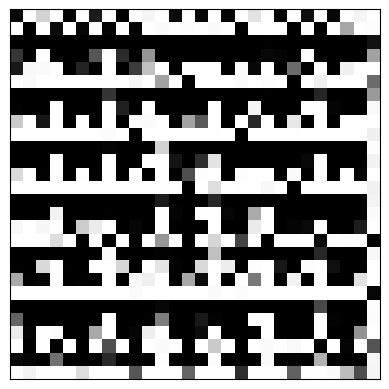

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


  1%|          | 1/94 [00:00<01:00,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


  2%|▏         | 2/94 [00:01<00:59,  1.56it/s]

2/2 [==============================] - 0s 8ms/step


  3%|▎         | 3/94 [00:01<00:57,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


  4%|▍         | 4/94 [00:02<01:09,  1.29it/s]

2/2 [==============================] - 0s 11ms/step


  5%|▌         | 5/94 [00:03<01:07,  1.32it/s]

2/2 [==============================] - 0s 5ms/step


  6%|▋         | 6/94 [00:04<01:04,  1.37it/s]

2/2 [==============================] - 0s 5ms/step


  7%|▋         | 7/94 [00:05<01:19,  1.10it/s]

2/2 [==============================] - 0s 8ms/step


  9%|▊         | 8/94 [00:06<01:18,  1.10it/s]

2/2 [==============================] - 0s 5ms/step


 10%|▉         | 9/94 [00:07<01:09,  1.23it/s]

2/2 [==============================] - 0s 6ms/step


 11%|█         | 10/94 [00:07<01:04,  1.31it/s]

2/2 [==============================] - 0s 8ms/step


 12%|█▏        | 11/94 [00:08<01:12,  1.15it/s]

2/2 [==============================] - 0s 14ms/step


 13%|█▎        | 12/94 [00:10<01:27,  1.06s/it]

2/2 [==============================] - 0s 5ms/step


 14%|█▍        | 13/94 [00:11<01:26,  1.06s/it]

2/2 [==============================] - 0s 6ms/step


 15%|█▍        | 14/94 [00:12<01:21,  1.01s/it]

2/2 [==============================] - 0s 4ms/step


 16%|█▌        | 15/94 [00:13<01:12,  1.09it/s]

2/2 [==============================] - 0s 5ms/step


 17%|█▋        | 16/94 [00:13<01:04,  1.21it/s]

2/2 [==============================] - 0s 4ms/step


 18%|█▊        | 17/94 [00:14<00:59,  1.30it/s]

2/2 [==============================] - 0s 5ms/step


 19%|█▉        | 18/94 [00:14<00:54,  1.39it/s]

2/2 [==============================] - 0s 5ms/step


 20%|██        | 19/94 [00:15<00:51,  1.46it/s]

2/2 [==============================] - 0s 5ms/step


 21%|██▏       | 20/94 [00:16<00:49,  1.50it/s]

2/2 [==============================] - 0s 5ms/step


 22%|██▏       | 21/94 [00:16<00:47,  1.54it/s]

2/2 [==============================] - 0s 4ms/step


 23%|██▎       | 22/94 [00:17<00:46,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 24%|██▍       | 23/94 [00:17<00:45,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 26%|██▌       | 24/94 [00:18<00:43,  1.60it/s]

2/2 [==============================] - 0s 5ms/step


 27%|██▋       | 25/94 [00:19<00:43,  1.58it/s]

2/2 [==============================] - 0s 4ms/step


 28%|██▊       | 26/94 [00:19<00:42,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 29%|██▊       | 27/94 [00:20<00:42,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 30%|██▉       | 28/94 [00:21<00:41,  1.60it/s]

2/2 [==============================] - 0s 5ms/step


 31%|███       | 29/94 [00:21<00:40,  1.60it/s]

2/2 [==============================] - 0s 5ms/step


 32%|███▏      | 30/94 [00:22<00:40,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 33%|███▎      | 31/94 [00:24<01:14,  1.18s/it]

2/2 [==============================] - 0s 5ms/step


 34%|███▍      | 32/94 [00:25<01:05,  1.05s/it]

2/2 [==============================] - 0s 4ms/step


 35%|███▌      | 33/94 [00:26<00:56,  1.08it/s]

2/2 [==============================] - 0s 5ms/step


 36%|███▌      | 34/94 [00:26<00:49,  1.20it/s]

2/2 [==============================] - 0s 6ms/step


 37%|███▋      | 35/94 [00:27<00:46,  1.28it/s]

2/2 [==============================] - 0s 5ms/step


 38%|███▊      | 36/94 [00:28<00:43,  1.34it/s]

2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 37/94 [00:28<00:40,  1.41it/s]

2/2 [==============================] - 0s 5ms/step


 40%|████      | 38/94 [00:29<00:39,  1.43it/s]

2/2 [==============================] - 0s 5ms/step


 41%|████▏     | 39/94 [00:30<00:37,  1.47it/s]

2/2 [==============================] - 0s 5ms/step


 43%|████▎     | 40/94 [00:30<00:35,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


 44%|████▎     | 41/94 [00:31<00:34,  1.53it/s]

2/2 [==============================] - 0s 4ms/step


 45%|████▍     | 42/94 [00:31<00:33,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 46%|████▌     | 43/94 [00:32<00:32,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 47%|████▋     | 44/94 [00:33<00:31,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 48%|████▊     | 45/94 [00:33<00:30,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 49%|████▉     | 46/94 [00:34<00:30,  1.60it/s]

2/2 [==============================] - 0s 5ms/step


 50%|█████     | 47/94 [00:35<00:29,  1.60it/s]

2/2 [==============================] - 0s 11ms/step


 51%|█████     | 48/94 [00:35<00:32,  1.43it/s]

2/2 [==============================] - 0s 4ms/step


 52%|█████▏    | 49/94 [00:36<00:34,  1.32it/s]

2/2 [==============================] - 0s 4ms/step


 53%|█████▎    | 50/94 [00:37<00:35,  1.25it/s]

2/2 [==============================] - 0s 9ms/step


 54%|█████▍    | 51/94 [00:38<00:33,  1.30it/s]

2/2 [==============================] - 0s 4ms/step


 55%|█████▌    | 52/94 [00:39<00:30,  1.37it/s]

2/2 [==============================] - 0s 5ms/step


 56%|█████▋    | 53/94 [00:39<00:28,  1.42it/s]

2/2 [==============================] - 0s 5ms/step


 57%|█████▋    | 54/94 [00:40<00:27,  1.47it/s]

2/2 [==============================] - 0s 4ms/step


 59%|█████▊    | 55/94 [00:40<00:25,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


 60%|█████▉    | 56/94 [00:41<00:24,  1.53it/s]

2/2 [==============================] - 0s 5ms/step


 61%|██████    | 57/94 [00:42<00:24,  1.53it/s]

2/2 [==============================] - 0s 4ms/step


 62%|██████▏   | 58/94 [00:42<00:23,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 63%|██████▎   | 59/94 [00:43<00:22,  1.58it/s]

2/2 [==============================] - 0s 6ms/step


 64%|██████▍   | 60/94 [00:44<00:21,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 65%|██████▍   | 61/94 [00:44<00:20,  1.59it/s]

2/2 [==============================] - 0s 7ms/step


 66%|██████▌   | 62/94 [00:45<00:20,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 67%|██████▋   | 63/94 [00:45<00:19,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 64/94 [00:46<00:18,  1.60it/s]

2/2 [==============================] - 0s 5ms/step


 69%|██████▉   | 65/94 [00:47<00:20,  1.38it/s]

2/2 [==============================] - 0s 15ms/step


 70%|███████   | 66/94 [00:49<00:28,  1.01s/it]

2/2 [==============================] - 0s 7ms/step


 71%|███████▏  | 67/94 [00:51<00:34,  1.27s/it]

2/2 [==============================] - 0s 9ms/step


 72%|███████▏  | 68/94 [00:52<00:35,  1.38s/it]

2/2 [==============================] - 0s 10ms/step


 73%|███████▎  | 69/94 [00:53<00:33,  1.35s/it]

2/2 [==============================] - 0s 5ms/step


 74%|███████▍  | 70/94 [00:54<00:28,  1.18s/it]

2/2 [==============================] - 0s 6ms/step


 76%|███████▌  | 71/94 [00:55<00:24,  1.09s/it]

2/2 [==============================] - 0s 11ms/step


 77%|███████▋  | 72/94 [00:56<00:24,  1.13s/it]

2/2 [==============================] - 0s 7ms/step


 78%|███████▊  | 73/94 [00:57<00:22,  1.05s/it]

2/2 [==============================] - 0s 18ms/step


 79%|███████▊  | 74/94 [00:58<00:19,  1.00it/s]

2/2 [==============================] - 0s 9ms/step


 80%|███████▉  | 75/94 [00:59<00:18,  1.02it/s]

2/2 [==============================] - 0s 5ms/step


 81%|████████  | 76/94 [01:00<00:16,  1.10it/s]

2/2 [==============================] - 0s 18ms/step


 82%|████████▏ | 77/94 [01:01<00:15,  1.08it/s]

2/2 [==============================] - 0s 5ms/step


 83%|████████▎ | 78/94 [01:02<00:16,  1.01s/it]

2/2 [==============================] - 0s 13ms/step


 84%|████████▍ | 79/94 [01:03<00:16,  1.07s/it]

2/2 [==============================] - 0s 5ms/step


 85%|████████▌ | 80/94 [01:04<00:14,  1.05s/it]

2/2 [==============================] - 0s 9ms/step


 86%|████████▌ | 81/94 [01:05<00:12,  1.01it/s]

2/2 [==============================] - 0s 13ms/step


 87%|████████▋ | 82/94 [01:06<00:11,  1.03it/s]

2/2 [==============================] - 0s 12ms/step


 88%|████████▊ | 83/94 [01:07<00:10,  1.06it/s]

2/2 [==============================] - 0s 5ms/step


 89%|████████▉ | 84/94 [01:08<00:09,  1.11it/s]

2/2 [==============================] - 0s 8ms/step


 90%|█████████ | 85/94 [01:09<00:08,  1.07it/s]

2/2 [==============================] - 0s 5ms/step


 91%|█████████▏| 86/94 [01:09<00:06,  1.19it/s]

2/2 [==============================] - 0s 4ms/step


 93%|█████████▎| 87/94 [01:10<00:06,  1.12it/s]

2/2 [==============================] - 0s 5ms/step


 94%|█████████▎| 88/94 [01:11<00:04,  1.22it/s]

2/2 [==============================] - 0s 4ms/step


 95%|█████████▍| 89/94 [01:12<00:03,  1.32it/s]

2/2 [==============================] - 0s 6ms/step


 96%|█████████▌| 90/94 [01:12<00:02,  1.40it/s]

2/2 [==============================] - 0s 5ms/step


 97%|█████████▋| 91/94 [01:13<00:02,  1.44it/s]

2/2 [==============================] - 0s 5ms/step


 98%|█████████▊| 92/94 [01:13<00:01,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


 99%|█████████▉| 93/94 [01:14<00:00,  1.47it/s]

2/2 [==============================] - 0s 4ms/step


100%|██████████| 94/94 [01:15<00:00,  1.24it/s]

Epoch: 3/10 	 Discriminator Loss: 0.852 Generator Loss: 0.852
1/1 [==============================] - 0s 26ms/step


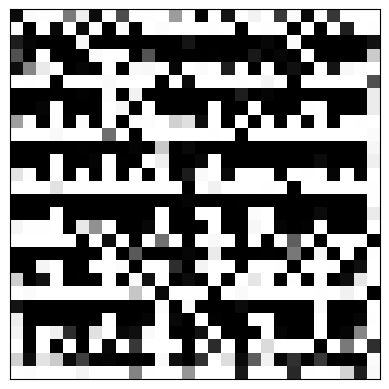

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


  1%|          | 1/94 [00:01<02:04,  1.33s/it]

2/2 [==============================] - 0s 6ms/step


  2%|▏         | 2/94 [00:02<01:51,  1.21s/it]

2/2 [==============================] - 0s 10ms/step


  3%|▎         | 3/94 [00:03<01:37,  1.07s/it]

2/2 [==============================] - 0s 7ms/step


  4%|▍         | 4/94 [00:04<01:35,  1.06s/it]

2/2 [==============================] - 0s 11ms/step


  5%|▌         | 5/94 [00:05<01:22,  1.08it/s]

2/2 [==============================] - 0s 4ms/step


  6%|▋         | 6/94 [00:05<01:14,  1.19it/s]

2/2 [==============================] - 0s 6ms/step


  7%|▋         | 7/94 [00:06<01:12,  1.20it/s]

2/2 [==============================] - 0s 6ms/step


  9%|▊         | 8/94 [00:07<01:10,  1.22it/s]

2/2 [==============================] - 0s 5ms/step


 10%|▉         | 9/94 [00:08<01:07,  1.25it/s]

2/2 [==============================] - 0s 4ms/step


 11%|█         | 10/94 [00:08<01:05,  1.28it/s]

2/2 [==============================] - 0s 5ms/step


 12%|█▏        | 11/94 [00:09<01:06,  1.26it/s]

2/2 [==============================] - 0s 6ms/step


 13%|█▎        | 12/94 [00:10<01:04,  1.28it/s]

2/2 [==============================] - 0s 5ms/step


 14%|█▍        | 13/94 [00:11<01:02,  1.30it/s]

2/2 [==============================] - 0s 7ms/step


 15%|█▍        | 14/94 [00:12<01:04,  1.23it/s]

2/2 [==============================] - 0s 13ms/step


 16%|█▌        | 15/94 [00:13<01:13,  1.08it/s]

2/2 [==============================] - 0s 7ms/step


 17%|█▋        | 16/94 [00:14<01:22,  1.05s/it]

2/2 [==============================] - 0s 5ms/step


 18%|█▊        | 17/94 [00:15<01:21,  1.06s/it]

2/2 [==============================] - 0s 5ms/step


 19%|█▉        | 18/94 [00:16<01:13,  1.03it/s]

2/2 [==============================] - 0s 6ms/step


 20%|██        | 19/94 [00:17<01:07,  1.11it/s]

2/2 [==============================] - 0s 8ms/step


 21%|██▏       | 20/94 [00:17<01:03,  1.16it/s]

2/2 [==============================] - 0s 6ms/step


 22%|██▏       | 21/94 [00:19<01:10,  1.03it/s]

2/2 [==============================] - 0s 4ms/step


 23%|██▎       | 22/94 [00:20<01:10,  1.02it/s]

2/2 [==============================] - 0s 5ms/step


 24%|██▍       | 23/94 [00:20<01:04,  1.10it/s]

2/2 [==============================] - 0s 8ms/step


 26%|██▌       | 24/94 [00:21<01:06,  1.06it/s]

2/2 [==============================] - 0s 14ms/step


 27%|██▋       | 25/94 [00:23<01:08,  1.01it/s]

2/2 [==============================] - 0s 12ms/step


 28%|██▊       | 26/94 [00:23<01:04,  1.05it/s]

2/2 [==============================] - 0s 5ms/step


 29%|██▊       | 27/94 [00:24<01:05,  1.03it/s]

2/2 [==============================] - 0s 5ms/step


 30%|██▉       | 28/94 [00:26<01:17,  1.18s/it]

2/2 [==============================] - 0s 18ms/step


 31%|███       | 29/94 [00:28<01:34,  1.45s/it]

2/2 [==============================] - 0s 6ms/step


 32%|███▏      | 30/94 [00:29<01:25,  1.34s/it]

2/2 [==============================] - 0s 4ms/step


 33%|███▎      | 31/94 [00:30<01:14,  1.18s/it]

2/2 [==============================] - 0s 14ms/step


 34%|███▍      | 32/94 [00:31<01:09,  1.12s/it]

2/2 [==============================] - 0s 12ms/step


 35%|███▌      | 33/94 [00:32<01:06,  1.08s/it]

2/2 [==============================] - 0s 10ms/step


 36%|███▌      | 34/94 [00:33<01:03,  1.05s/it]

2/2 [==============================] - 0s 10ms/step


 37%|███▋      | 35/94 [00:34<01:02,  1.07s/it]

2/2 [==============================] - 0s 10ms/step


 38%|███▊      | 36/94 [00:35<01:03,  1.09s/it]

2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 37/94 [00:36<01:02,  1.09s/it]

2/2 [==============================] - 0s 10ms/step


 40%|████      | 38/94 [00:38<01:02,  1.11s/it]

2/2 [==============================] - 0s 10ms/step


 41%|████▏     | 39/94 [00:39<01:04,  1.18s/it]

2/2 [==============================] - 0s 10ms/step


 43%|████▎     | 40/94 [00:41<01:11,  1.33s/it]

2/2 [==============================] - 0s 12ms/step


 44%|████▎     | 41/94 [00:42<01:12,  1.37s/it]

2/2 [==============================] - 0s 12ms/step


 45%|████▍     | 42/94 [00:43<01:06,  1.29s/it]

2/2 [==============================] - 0s 4ms/step


 46%|████▌     | 43/94 [00:44<00:55,  1.09s/it]

2/2 [==============================] - 0s 6ms/step


 47%|████▋     | 44/94 [00:44<00:47,  1.06it/s]

2/2 [==============================] - 0s 4ms/step


 48%|████▊     | 45/94 [00:45<00:41,  1.18it/s]

2/2 [==============================] - 0s 4ms/step


 49%|████▉     | 46/94 [00:46<00:37,  1.29it/s]

2/2 [==============================] - 0s 5ms/step


 50%|█████     | 47/94 [00:46<00:34,  1.37it/s]

2/2 [==============================] - 0s 4ms/step


 51%|█████     | 48/94 [00:47<00:32,  1.43it/s]

2/2 [==============================] - 0s 5ms/step


 52%|█████▏    | 49/94 [00:47<00:30,  1.49it/s]

2/2 [==============================] - 0s 6ms/step


 53%|█████▎    | 50/94 [00:48<00:28,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 54%|█████▍    | 51/94 [00:49<00:27,  1.55it/s]

2/2 [==============================] - 0s 6ms/step


 55%|█████▌    | 52/94 [00:49<00:26,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 56%|█████▋    | 53/94 [00:50<00:26,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 57%|█████▋    | 54/94 [00:51<00:25,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 59%|█████▊    | 55/94 [00:51<00:24,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 60%|█████▉    | 56/94 [00:52<00:26,  1.44it/s]

2/2 [==============================] - 0s 5ms/step


 61%|██████    | 57/94 [00:53<00:28,  1.31it/s]

2/2 [==============================] - 0s 5ms/step


 62%|██████▏   | 58/94 [00:54<00:29,  1.24it/s]

2/2 [==============================] - 0s 4ms/step


 63%|██████▎   | 59/94 [00:55<00:27,  1.28it/s]

2/2 [==============================] - 0s 5ms/step


 64%|██████▍   | 60/94 [00:55<00:25,  1.36it/s]

2/2 [==============================] - 0s 6ms/step


 65%|██████▍   | 61/94 [00:56<00:24,  1.36it/s]

2/2 [==============================] - 0s 11ms/step


 66%|██████▌   | 62/94 [00:57<00:29,  1.07it/s]

2/2 [==============================] - 0s 8ms/step


 67%|██████▋   | 63/94 [00:58<00:30,  1.03it/s]

2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 64/94 [00:59<00:28,  1.07it/s]

2/2 [==============================] - 0s 4ms/step


 69%|██████▉   | 65/94 [01:00<00:24,  1.19it/s]

2/2 [==============================] - 0s 4ms/step


 70%|███████   | 66/94 [01:01<00:21,  1.29it/s]

2/2 [==============================] - 0s 6ms/step


 71%|███████▏  | 67/94 [01:01<00:19,  1.37it/s]

2/2 [==============================] - 0s 5ms/step


 72%|███████▏  | 68/94 [01:02<00:18,  1.42it/s]

2/2 [==============================] - 0s 5ms/step


 73%|███████▎  | 69/94 [01:02<00:17,  1.47it/s]

2/2 [==============================] - 0s 4ms/step


 74%|███████▍  | 70/94 [01:07<00:45,  1.91s/it]

2/2 [==============================] - 0s 8ms/step


 76%|███████▌  | 71/94 [01:08<00:38,  1.66s/it]

2/2 [==============================] - 0s 5ms/step


 77%|███████▋  | 72/94 [01:09<00:31,  1.43s/it]

2/2 [==============================] - 0s 6ms/step


 78%|███████▊  | 73/94 [01:10<00:27,  1.31s/it]

2/2 [==============================] - 0s 5ms/step


 79%|███████▊  | 74/94 [01:11<00:24,  1.22s/it]

2/2 [==============================] - 0s 12ms/step


 80%|███████▉  | 75/94 [01:12<00:22,  1.19s/it]

2/2 [==============================] - 0s 12ms/step


 81%|████████  | 76/94 [01:13<00:20,  1.15s/it]

2/2 [==============================] - 0s 11ms/step


 82%|████████▏ | 77/94 [01:14<00:18,  1.10s/it]

2/2 [==============================] - 0s 12ms/step


 83%|████████▎ | 78/94 [01:16<00:20,  1.28s/it]

2/2 [==============================] - 0s 15ms/step


 84%|████████▍ | 79/94 [01:17<00:17,  1.19s/it]

2/2 [==============================] - 0s 12ms/step


 85%|████████▌ | 80/94 [01:19<00:18,  1.29s/it]

2/2 [==============================] - 0s 7ms/step


 86%|████████▌ | 81/94 [01:20<00:17,  1.36s/it]

2/2 [==============================] - 0s 11ms/step


 87%|████████▋ | 82/94 [01:22<00:16,  1.40s/it]

2/2 [==============================] - 0s 14ms/step


 88%|████████▊ | 83/94 [01:23<00:16,  1.47s/it]

2/2 [==============================] - 0s 12ms/step


 89%|████████▉ | 84/94 [01:24<00:14,  1.42s/it]

2/2 [==============================] - 0s 12ms/step


 90%|█████████ | 85/94 [01:27<00:15,  1.70s/it]

2/2 [==============================] - 0s 10ms/step


 91%|█████████▏| 86/94 [01:29<00:15,  1.89s/it]

2/2 [==============================] - 0s 9ms/step


 93%|█████████▎| 87/94 [01:31<00:12,  1.77s/it]

2/2 [==============================] - 0s 10ms/step


 94%|█████████▎| 88/94 [01:33<00:10,  1.82s/it]

2/2 [==============================] - 0s 8ms/step


 95%|█████████▍| 89/94 [01:35<00:10,  2.00s/it]

2/2 [==============================] - 0s 16ms/step


 96%|█████████▌| 90/94 [01:37<00:07,  1.95s/it]

2/2 [==============================] - 0s 6ms/step


 97%|█████████▋| 91/94 [01:38<00:04,  1.61s/it]

2/2 [==============================] - 0s 11ms/step


 98%|█████████▊| 92/94 [01:39<00:02,  1.42s/it]

2/2 [==============================] - 0s 4ms/step


 99%|█████████▉| 93/94 [01:40<00:01,  1.28s/it]

2/2 [==============================] - 0s 12ms/step


100%|██████████| 94/94 [01:40<00:00,  1.07s/it]

Epoch: 4/10 	 Discriminator Loss: 0.869 Generator Loss: 0.869
1/1 [==============================] - 0s 17ms/step


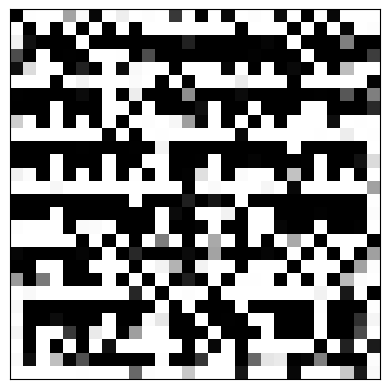

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


  1%|          | 1/94 [00:00<01:10,  1.32it/s]

2/2 [==============================] - 0s 10ms/step


  2%|▏         | 2/94 [00:01<01:32,  1.01s/it]

2/2 [==============================] - 0s 12ms/step


  3%|▎         | 3/94 [00:02<01:23,  1.09it/s]

2/2 [==============================] - 0s 10ms/step


  4%|▍         | 4/94 [00:03<01:27,  1.03it/s]

2/2 [==============================] - 0s 12ms/step


  5%|▌         | 5/94 [00:05<01:45,  1.18s/it]

2/2 [==============================] - 0s 8ms/step


  6%|▋         | 6/94 [00:06<01:36,  1.10s/it]

2/2 [==============================] - 0s 4ms/step


  7%|▋         | 7/94 [00:07<01:30,  1.04s/it]

2/2 [==============================] - 0s 8ms/step


  9%|▊         | 8/94 [00:08<01:23,  1.03it/s]

2/2 [==============================] - 0s 6ms/step


 10%|▉         | 9/94 [00:09<01:26,  1.01s/it]

2/2 [==============================] - 0s 14ms/step


 11%|█         | 10/94 [00:10<01:24,  1.00s/it]

2/2 [==============================] - 0s 5ms/step


 12%|█▏        | 11/94 [00:10<01:13,  1.12it/s]

2/2 [==============================] - 0s 5ms/step


 13%|█▎        | 12/94 [00:11<01:10,  1.16it/s]

2/2 [==============================] - 0s 10ms/step


 14%|█▍        | 13/94 [00:12<01:09,  1.16it/s]

2/2 [==============================] - 0s 12ms/step


 15%|█▍        | 14/94 [00:13<01:11,  1.12it/s]

2/2 [==============================] - 0s 5ms/step


 16%|█▌        | 15/94 [00:14<01:07,  1.18it/s]

2/2 [==============================] - 0s 13ms/step


 17%|█▋        | 16/94 [00:14<01:05,  1.20it/s]

2/2 [==============================] - 0s 15ms/step


 18%|█▊        | 17/94 [00:15<01:06,  1.16it/s]

2/2 [==============================] - 0s 10ms/step


 19%|█▉        | 18/94 [00:16<01:03,  1.20it/s]

2/2 [==============================] - 0s 9ms/step


 20%|██        | 19/94 [00:17<01:06,  1.13it/s]

2/2 [==============================] - 0s 5ms/step


 21%|██▏       | 20/94 [00:18<01:11,  1.04it/s]

2/2 [==============================] - 0s 5ms/step


 22%|██▏       | 21/94 [00:19<01:13,  1.01s/it]

2/2 [==============================] - 0s 6ms/step


 23%|██▎       | 22/94 [00:20<01:10,  1.02it/s]

2/2 [==============================] - 0s 5ms/step


 24%|██▍       | 23/94 [00:21<01:07,  1.06it/s]

2/2 [==============================] - 0s 5ms/step


 26%|██▌       | 24/94 [00:22<01:06,  1.05it/s]

2/2 [==============================] - 0s 6ms/step


 27%|██▋       | 25/94 [00:23<01:06,  1.03it/s]

2/2 [==============================] - 0s 5ms/step


 28%|██▊       | 26/94 [00:24<01:02,  1.09it/s]

2/2 [==============================] - 0s 6ms/step


 29%|██▊       | 27/94 [00:25<00:58,  1.15it/s]

2/2 [==============================] - 0s 12ms/step


 30%|██▉       | 28/94 [00:26<00:58,  1.13it/s]

2/2 [==============================] - 0s 13ms/step


 31%|███       | 29/94 [00:26<00:55,  1.17it/s]

2/2 [==============================] - 0s 12ms/step


 32%|███▏      | 30/94 [00:27<00:55,  1.16it/s]

2/2 [==============================] - 0s 14ms/step


 33%|███▎      | 31/94 [00:28<00:54,  1.15it/s]

2/2 [==============================] - 0s 5ms/step


 34%|███▍      | 32/94 [00:29<00:54,  1.13it/s]

2/2 [==============================] - 0s 14ms/step


 35%|███▌      | 33/94 [00:30<00:54,  1.11it/s]

2/2 [==============================] - 0s 12ms/step


 36%|███▌      | 34/94 [00:31<01:03,  1.06s/it]

2/2 [==============================] - 0s 10ms/step


 37%|███▋      | 35/94 [00:33<01:04,  1.10s/it]

2/2 [==============================] - 0s 14ms/step


 38%|███▊      | 36/94 [00:34<01:05,  1.13s/it]

2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 37/94 [00:35<00:57,  1.01s/it]

2/2 [==============================] - 0s 13ms/step


 40%|████      | 38/94 [00:35<00:51,  1.08it/s]

2/2 [==============================] - 0s 16ms/step


 41%|████▏     | 39/94 [00:36<00:53,  1.03it/s]

2/2 [==============================] - 0s 4ms/step


 43%|████▎     | 40/94 [00:37<00:49,  1.09it/s]

2/2 [==============================] - 0s 13ms/step


 44%|████▎     | 41/94 [00:38<00:48,  1.09it/s]

2/2 [==============================] - 0s 5ms/step


 45%|████▍     | 42/94 [00:39<00:48,  1.07it/s]

2/2 [==============================] - 0s 6ms/step


 46%|████▌     | 43/94 [00:40<00:46,  1.09it/s]

2/2 [==============================] - 0s 5ms/step


 47%|████▋     | 44/94 [00:41<00:48,  1.03it/s]

2/2 [==============================] - 0s 12ms/step


 48%|████▊     | 45/94 [00:42<00:44,  1.10it/s]

2/2 [==============================] - 0s 5ms/step


 49%|████▉     | 46/94 [00:42<00:39,  1.20it/s]

2/2 [==============================] - 0s 11ms/step


 50%|█████     | 47/94 [00:43<00:39,  1.20it/s]

2/2 [==============================] - 0s 7ms/step


 51%|█████     | 48/94 [00:45<00:47,  1.03s/it]

2/2 [==============================] - 0s 7ms/step


 52%|█████▏    | 49/94 [00:46<00:54,  1.21s/it]

2/2 [==============================] - 0s 5ms/step


 53%|█████▎    | 50/94 [00:47<00:46,  1.06s/it]

2/2 [==============================] - 0s 4ms/step


 54%|█████▍    | 51/94 [00:48<00:40,  1.07it/s]

2/2 [==============================] - 0s 4ms/step


 55%|█████▌    | 52/94 [00:48<00:35,  1.19it/s]

2/2 [==============================] - 0s 5ms/step


 56%|█████▋    | 53/94 [00:49<00:32,  1.27it/s]

2/2 [==============================] - 0s 4ms/step


 57%|█████▋    | 54/94 [00:50<00:29,  1.35it/s]

2/2 [==============================] - 0s 5ms/step


 59%|█████▊    | 55/94 [00:50<00:27,  1.42it/s]

2/2 [==============================] - 0s 4ms/step


 60%|█████▉    | 56/94 [00:51<00:25,  1.47it/s]

2/2 [==============================] - 0s 5ms/step


 61%|██████    | 57/94 [00:52<00:24,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


 62%|██████▏   | 58/94 [00:52<00:23,  1.54it/s]

2/2 [==============================] - 0s 6ms/step


 63%|██████▎   | 59/94 [00:53<00:22,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 64%|██████▍   | 60/94 [00:53<00:21,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 65%|██████▍   | 61/94 [00:54<00:21,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 66%|██████▌   | 62/94 [00:55<00:20,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 67%|██████▋   | 63/94 [00:55<00:19,  1.58it/s]

2/2 [==============================] - 0s 7ms/step


 68%|██████▊   | 64/94 [00:56<00:19,  1.58it/s]

2/2 [==============================] - 0s 4ms/step


 69%|██████▉   | 65/94 [00:57<00:18,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 70%|███████   | 66/94 [00:57<00:19,  1.41it/s]

2/2 [==============================] - 0s 5ms/step


 71%|███████▏  | 67/94 [00:58<00:21,  1.28it/s]

2/2 [==============================] - 0s 8ms/step


 72%|███████▏  | 68/94 [00:59<00:21,  1.21it/s]

2/2 [==============================] - 0s 5ms/step


 73%|███████▎  | 69/94 [01:00<00:19,  1.27it/s]

2/2 [==============================] - 0s 5ms/step


 74%|███████▍  | 70/94 [01:01<00:18,  1.32it/s]

2/2 [==============================] - 0s 12ms/step


 76%|███████▌  | 71/94 [01:01<00:17,  1.34it/s]

2/2 [==============================] - 0s 5ms/step


 77%|███████▋  | 72/94 [01:02<00:15,  1.41it/s]

2/2 [==============================] - 0s 5ms/step


 78%|███████▊  | 73/94 [01:03<00:14,  1.46it/s]

2/2 [==============================] - 0s 6ms/step


 79%|███████▊  | 74/94 [01:03<00:13,  1.48it/s]

2/2 [==============================] - 0s 7ms/step


 80%|███████▉  | 75/94 [01:04<00:14,  1.32it/s]

2/2 [==============================] - 0s 6ms/step


 81%|████████  | 76/94 [01:05<00:14,  1.27it/s]

2/2 [==============================] - 0s 11ms/step


 82%|████████▏ | 77/94 [01:06<00:14,  1.21it/s]

2/2 [==============================] - 0s 12ms/step


 83%|████████▎ | 78/94 [01:07<00:14,  1.11it/s]

2/2 [==============================] - 0s 6ms/step


 84%|████████▍ | 79/94 [01:08<00:12,  1.22it/s]

2/2 [==============================] - 0s 5ms/step


 85%|████████▌ | 80/94 [01:09<00:12,  1.10it/s]

2/2 [==============================] - 0s 6ms/step


 86%|████████▌ | 81/94 [01:10<00:13,  1.05s/it]

2/2 [==============================] - 0s 13ms/step


 87%|████████▋ | 82/94 [01:12<00:16,  1.34s/it]

2/2 [==============================] - 0s 9ms/step


 88%|████████▊ | 83/94 [01:14<00:15,  1.41s/it]

2/2 [==============================] - 0s 6ms/step


 89%|████████▉ | 84/94 [01:15<00:13,  1.34s/it]

2/2 [==============================] - 0s 13ms/step


 90%|█████████ | 85/94 [01:16<00:11,  1.32s/it]

2/2 [==============================] - 0s 10ms/step


 91%|█████████▏| 86/94 [01:17<00:09,  1.25s/it]

2/2 [==============================] - 0s 11ms/step


 93%|█████████▎| 87/94 [01:18<00:08,  1.15s/it]

2/2 [==============================] - 0s 12ms/step


 94%|█████████▎| 88/94 [01:19<00:06,  1.12s/it]

2/2 [==============================] - 0s 14ms/step


 95%|█████████▍| 89/94 [01:20<00:05,  1.02s/it]

2/2 [==============================] - 0s 6ms/step


 96%|█████████▌| 90/94 [01:21<00:03,  1.10it/s]

2/2 [==============================] - 0s 6ms/step


 97%|█████████▋| 91/94 [01:22<00:02,  1.15it/s]

2/2 [==============================] - 0s 5ms/step


 98%|█████████▊| 92/94 [01:23<00:01,  1.13it/s]

2/2 [==============================] - 0s 6ms/step


 99%|█████████▉| 93/94 [01:25<00:01,  1.25s/it]

2/2 [==============================] - 0s 5ms/step


100%|██████████| 94/94 [01:27<00:00,  1.08it/s]

Epoch: 5/10 	 Discriminator Loss: 0.906 Generator Loss: 0.906
1/1 [==============================] - 0s 18ms/step


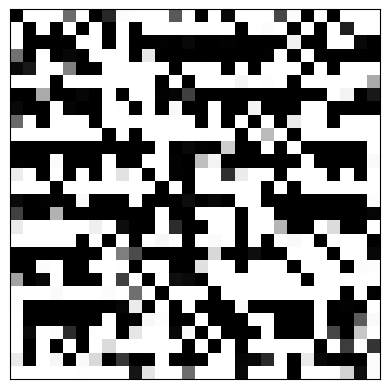

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  1%|          | 1/94 [00:00<01:04,  1.43it/s]

2/2 [==============================] - 0s 14ms/step


  2%|▏         | 2/94 [00:01<01:04,  1.42it/s]

2/2 [==============================] - 0s 6ms/step


  3%|▎         | 3/94 [00:02<01:01,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


  4%|▍         | 4/94 [00:02<00:59,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


  5%|▌         | 5/94 [00:03<00:59,  1.50it/s]

2/2 [==============================] - 0s 6ms/step


  6%|▋         | 6/94 [00:04<00:58,  1.50it/s]

2/2 [==============================] - 0s 5ms/step


  7%|▋         | 7/94 [00:04<00:57,  1.50it/s]

2/2 [==============================] - 0s 5ms/step


  9%|▊         | 8/94 [00:05<00:56,  1.51it/s]

2/2 [==============================] - 0s 7ms/step


 10%|▉         | 9/94 [00:05<00:55,  1.53it/s]

2/2 [==============================] - 0s 6ms/step


 11%|█         | 10/94 [00:06<00:54,  1.54it/s]

2/2 [==============================] - 0s 6ms/step


 12%|█▏        | 11/94 [00:07<00:53,  1.54it/s]

2/2 [==============================] - 0s 6ms/step


 13%|█▎        | 12/94 [00:07<00:53,  1.53it/s]

2/2 [==============================] - 0s 6ms/step


 14%|█▍        | 13/94 [00:08<00:52,  1.53it/s]

2/2 [==============================] - 0s 6ms/step


 15%|█▍        | 14/94 [00:09<00:52,  1.53it/s]

2/2 [==============================] - 0s 6ms/step


 16%|█▌        | 15/94 [00:09<00:51,  1.53it/s]

2/2 [==============================] - 0s 6ms/step


 17%|█▋        | 16/94 [00:10<00:59,  1.32it/s]

2/2 [==============================] - 0s 5ms/step


 18%|█▊        | 17/94 [00:11<01:02,  1.23it/s]

2/2 [==============================] - 0s 7ms/step


 19%|█▉        | 18/94 [00:12<01:04,  1.18it/s]

2/2 [==============================] - 0s 4ms/step


 20%|██        | 19/94 [00:13<00:58,  1.28it/s]

2/2 [==============================] - 0s 6ms/step


 21%|██▏       | 20/94 [00:14<00:55,  1.33it/s]

2/2 [==============================] - 0s 5ms/step


 22%|██▏       | 21/94 [00:14<00:52,  1.39it/s]

2/2 [==============================] - 0s 6ms/step


 23%|██▎       | 22/94 [00:15<00:50,  1.44it/s]

2/2 [==============================] - 0s 4ms/step


 24%|██▍       | 23/94 [00:16<00:48,  1.47it/s]

2/2 [==============================] - 0s 4ms/step


 26%|██▌       | 24/94 [00:16<00:46,  1.50it/s]

2/2 [==============================] - 0s 6ms/step


 27%|██▋       | 25/94 [00:17<00:45,  1.51it/s]

2/2 [==============================] - 0s 6ms/step


 28%|██▊       | 26/94 [00:17<00:44,  1.53it/s]

2/2 [==============================] - 0s 4ms/step


 29%|██▊       | 27/94 [00:18<00:43,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 30%|██▉       | 28/94 [00:19<00:42,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 31%|███       | 29/94 [00:19<00:42,  1.53it/s]

2/2 [==============================] - 0s 6ms/step


 32%|███▏      | 30/94 [00:20<00:41,  1.54it/s]

2/2 [==============================] - 0s 6ms/step


 33%|███▎      | 31/94 [00:21<00:40,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 34%|███▍      | 32/94 [00:21<00:40,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 35%|███▌      | 33/94 [00:22<00:39,  1.53it/s]

2/2 [==============================] - 0s 5ms/step


 36%|███▌      | 34/94 [00:23<00:43,  1.37it/s]

2/2 [==============================] - 0s 5ms/step


 37%|███▋      | 35/94 [00:24<00:47,  1.25it/s]

2/2 [==============================] - 0s 5ms/step


 38%|███▊      | 36/94 [00:25<00:49,  1.17it/s]

2/2 [==============================] - 0s 13ms/step


 39%|███▉      | 37/94 [00:26<00:53,  1.06it/s]

2/2 [==============================] - 0s 6ms/step


 40%|████      | 38/94 [00:27<00:48,  1.16it/s]

2/2 [==============================] - 0s 6ms/step


 41%|████▏     | 39/94 [00:27<00:43,  1.25it/s]

2/2 [==============================] - 0s 5ms/step


 43%|████▎     | 40/94 [00:28<00:40,  1.32it/s]

2/2 [==============================] - 0s 7ms/step


 44%|████▎     | 41/94 [00:29<00:38,  1.38it/s]

2/2 [==============================] - 0s 4ms/step


 45%|████▍     | 42/94 [00:31<01:08,  1.32s/it]

2/2 [==============================] - 0s 6ms/step


 46%|████▌     | 43/94 [00:32<00:57,  1.12s/it]

2/2 [==============================] - 0s 5ms/step


 47%|████▋     | 44/94 [00:33<00:49,  1.02it/s]

2/2 [==============================] - 0s 6ms/step


 48%|████▊     | 45/94 [00:33<00:43,  1.12it/s]

2/2 [==============================] - 0s 5ms/step


 49%|████▉     | 46/94 [00:34<00:39,  1.21it/s]

2/2 [==============================] - 0s 5ms/step


 50%|█████     | 47/94 [00:35<00:36,  1.29it/s]

2/2 [==============================] - 0s 5ms/step


 51%|█████     | 48/94 [00:35<00:36,  1.28it/s]

2/2 [==============================] - 0s 5ms/step


 52%|█████▏    | 49/94 [00:36<00:37,  1.21it/s]

2/2 [==============================] - 0s 9ms/step


 53%|█████▎    | 50/94 [00:37<00:37,  1.17it/s]

2/2 [==============================] - 0s 4ms/step


 54%|█████▍    | 51/94 [00:38<00:35,  1.20it/s]

2/2 [==============================] - 0s 5ms/step


 55%|█████▌    | 52/94 [00:39<00:32,  1.29it/s]

2/2 [==============================] - 0s 6ms/step


 56%|█████▋    | 53/94 [00:39<00:30,  1.35it/s]

2/2 [==============================] - 0s 5ms/step


 57%|█████▋    | 54/94 [00:40<00:28,  1.39it/s]

2/2 [==============================] - 0s 6ms/step


 59%|█████▊    | 55/94 [00:41<00:27,  1.44it/s]

2/2 [==============================] - 0s 6ms/step


 60%|█████▉    | 56/94 [00:41<00:26,  1.45it/s]

2/2 [==============================] - 0s 6ms/step


 61%|██████    | 57/94 [00:42<00:25,  1.47it/s]

2/2 [==============================] - 0s 6ms/step


 62%|██████▏   | 58/94 [00:43<00:24,  1.49it/s]

2/2 [==============================] - 0s 6ms/step


 63%|██████▎   | 59/94 [00:43<00:23,  1.49it/s]

2/2 [==============================] - 0s 6ms/step


 64%|██████▍   | 60/94 [00:44<00:22,  1.50it/s]

2/2 [==============================] - 0s 4ms/step


 65%|██████▍   | 61/94 [00:45<00:21,  1.53it/s]

2/2 [==============================] - 0s 4ms/step


 66%|██████▌   | 62/94 [00:45<00:20,  1.53it/s]

2/2 [==============================] - 0s 6ms/step


 67%|██████▋   | 63/94 [00:46<00:20,  1.54it/s]

2/2 [==============================] - 0s 13ms/step


 68%|██████▊   | 64/94 [00:47<00:19,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


 69%|██████▉   | 65/94 [00:47<00:19,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 70%|███████   | 66/94 [00:48<00:18,  1.49it/s]

2/2 [==============================] - 0s 6ms/step


 71%|███████▏  | 67/94 [00:49<00:20,  1.34it/s]

2/2 [==============================] - 0s 5ms/step


 72%|███████▏  | 68/94 [00:50<00:20,  1.24it/s]

2/2 [==============================] - 0s 6ms/step


 73%|███████▎  | 69/94 [00:51<00:20,  1.21it/s]

2/2 [==============================] - 0s 6ms/step


 74%|███████▍  | 70/94 [00:51<00:18,  1.29it/s]

2/2 [==============================] - 0s 6ms/step


 76%|███████▌  | 71/94 [00:52<00:16,  1.36it/s]

2/2 [==============================] - 0s 4ms/step


 77%|███████▋  | 72/94 [00:53<00:15,  1.42it/s]

2/2 [==============================] - 0s 5ms/step


 78%|███████▊  | 73/94 [00:53<00:14,  1.43it/s]

2/2 [==============================] - 0s 5ms/step


 79%|███████▊  | 74/94 [00:54<00:13,  1.46it/s]

2/2 [==============================] - 0s 5ms/step


 80%|███████▉  | 75/94 [00:55<00:12,  1.48it/s]

2/2 [==============================] - 0s 7ms/step


 81%|████████  | 76/94 [00:55<00:12,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 77/94 [00:56<00:11,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 83%|████████▎ | 78/94 [00:57<00:10,  1.54it/s]

2/2 [==============================] - 0s 6ms/step


 84%|████████▍ | 79/94 [00:57<00:09,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 85%|████████▌ | 80/94 [00:58<00:08,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 81/94 [00:58<00:08,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 87%|████████▋ | 82/94 [00:59<00:07,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 88%|████████▊ | 83/94 [01:00<00:07,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 89%|████████▉ | 84/94 [01:00<00:06,  1.57it/s]

2/2 [==============================] - 0s 6ms/step


 90%|█████████ | 85/94 [01:01<00:06,  1.42it/s]

2/2 [==============================] - 0s 4ms/step


 91%|█████████▏| 86/94 [01:02<00:06,  1.32it/s]

2/2 [==============================] - 0s 5ms/step


 93%|█████████▎| 87/94 [01:03<00:05,  1.22it/s]

2/2 [==============================] - 0s 5ms/step


 94%|█████████▎| 88/94 [01:04<00:04,  1.27it/s]

2/2 [==============================] - 0s 5ms/step


 95%|█████████▍| 89/94 [01:04<00:03,  1.34it/s]

2/2 [==============================] - 0s 7ms/step


 96%|█████████▌| 90/94 [01:05<00:02,  1.40it/s]

2/2 [==============================] - 0s 6ms/step


 97%|█████████▋| 91/94 [01:06<00:02,  1.45it/s]

2/2 [==============================] - 0s 6ms/step


 98%|█████████▊| 92/94 [01:06<00:01,  1.47it/s]

2/2 [==============================] - 0s 5ms/step


 99%|█████████▉| 93/94 [01:07<00:00,  1.48it/s]

2/2 [==============================] - 0s 14ms/step


100%|██████████| 94/94 [01:08<00:00,  1.37it/s]

Epoch: 6/10 	 Discriminator Loss: 0.910 Generator Loss: 0.910
1/1 [==============================] - 0s 51ms/step


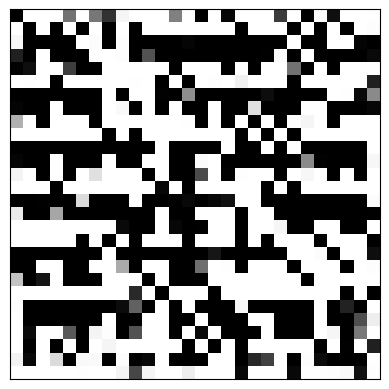

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 14ms/step


  1%|          | 1/94 [00:01<01:38,  1.06s/it]

2/2 [==============================] - 0s 12ms/step


  2%|▏         | 2/94 [00:02<01:52,  1.22s/it]

2/2 [==============================] - 0s 13ms/step


  3%|▎         | 3/94 [00:03<01:57,  1.29s/it]

2/2 [==============================] - 0s 6ms/step


  4%|▍         | 4/94 [00:04<01:33,  1.04s/it]

2/2 [==============================] - 0s 4ms/step


  5%|▌         | 5/94 [00:05<01:25,  1.05it/s]

2/2 [==============================] - 0s 9ms/step


  6%|▋         | 6/94 [00:06<01:28,  1.00s/it]

2/2 [==============================] - 0s 9ms/step


  7%|▋         | 7/94 [00:07<01:45,  1.21s/it]

2/2 [==============================] - 0s 5ms/step


  9%|▊         | 8/94 [00:09<01:43,  1.21s/it]

2/2 [==============================] - 0s 5ms/step


 10%|▉         | 9/94 [00:10<01:37,  1.14s/it]

2/2 [==============================] - 0s 6ms/step


 11%|█         | 10/94 [00:11<01:34,  1.12s/it]

2/2 [==============================] - 0s 9ms/step


 12%|█▏        | 11/94 [00:12<01:24,  1.02s/it]

2/2 [==============================] - 0s 5ms/step


 13%|█▎        | 12/94 [00:12<01:14,  1.11it/s]

2/2 [==============================] - 0s 5ms/step


 14%|█▍        | 13/94 [00:13<01:06,  1.22it/s]

2/2 [==============================] - 0s 5ms/step


 15%|█▍        | 14/94 [00:13<01:00,  1.31it/s]

2/2 [==============================] - 0s 5ms/step


 16%|█▌        | 15/94 [00:14<01:02,  1.26it/s]

2/2 [==============================] - 0s 18ms/step


 17%|█▋        | 16/94 [00:15<01:05,  1.19it/s]

2/2 [==============================] - 0s 24ms/step


 18%|█▊        | 17/94 [00:16<01:11,  1.07it/s]

2/2 [==============================] - 0s 14ms/step


 19%|█▉        | 18/94 [00:18<01:21,  1.08s/it]

2/2 [==============================] - 0s 4ms/step


 20%|██        | 19/94 [00:19<01:25,  1.14s/it]

2/2 [==============================] - 0s 12ms/step


 21%|██▏       | 20/94 [00:20<01:29,  1.21s/it]

2/2 [==============================] - 0s 15ms/step


 22%|██▏       | 21/94 [00:22<01:25,  1.18s/it]

2/2 [==============================] - 0s 5ms/step


 23%|██▎       | 22/94 [00:22<01:16,  1.06s/it]

2/2 [==============================] - 0s 10ms/step


 24%|██▍       | 23/94 [00:23<01:10,  1.01it/s]

2/2 [==============================] - 0s 16ms/step


 26%|██▌       | 24/94 [00:24<01:10,  1.01s/it]

2/2 [==============================] - 0s 17ms/step


 27%|██▋       | 25/94 [00:25<01:09,  1.01s/it]

2/2 [==============================] - 0s 4ms/step


 28%|██▊       | 26/94 [00:26<01:04,  1.05it/s]

2/2 [==============================] - 0s 6ms/step


 29%|██▊       | 27/94 [00:27<01:00,  1.11it/s]

2/2 [==============================] - 0s 6ms/step


 30%|██▉       | 28/94 [00:28<00:56,  1.16it/s]

2/2 [==============================] - 0s 5ms/step


 31%|███       | 29/94 [00:29<00:59,  1.10it/s]

2/2 [==============================] - 0s 4ms/step


 32%|███▏      | 30/94 [00:30<00:58,  1.10it/s]

2/2 [==============================] - 0s 16ms/step


 33%|███▎      | 31/94 [00:31<01:05,  1.04s/it]

2/2 [==============================] - 0s 5ms/step


 34%|███▍      | 32/94 [00:32<01:06,  1.07s/it]

2/2 [==============================] - 0s 4ms/step


 35%|███▌      | 33/94 [00:33<01:09,  1.15s/it]

2/2 [==============================] - 0s 10ms/step


 36%|███▌      | 34/94 [00:34<01:06,  1.10s/it]

2/2 [==============================] - 0s 6ms/step


 37%|███▋      | 35/94 [00:35<01:01,  1.05s/it]

2/2 [==============================] - 0s 5ms/step


 38%|███▊      | 36/94 [00:36<00:56,  1.02it/s]

2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 37/94 [00:37<00:53,  1.07it/s]

2/2 [==============================] - 0s 14ms/step


 40%|████      | 38/94 [00:39<01:11,  1.28s/it]

2/2 [==============================] - 0s 15ms/step


 41%|████▏     | 39/94 [00:41<01:23,  1.52s/it]

2/2 [==============================] - 0s 20ms/step


 43%|████▎     | 40/94 [00:42<01:16,  1.42s/it]

2/2 [==============================] - 0s 4ms/step


 44%|████▎     | 41/94 [00:43<01:10,  1.33s/it]

2/2 [==============================] - 0s 6ms/step


 45%|████▍     | 42/94 [00:46<01:34,  1.81s/it]

2/2 [==============================] - 0s 15ms/step


 46%|████▌     | 43/94 [00:48<01:28,  1.74s/it]

2/2 [==============================] - 0s 5ms/step


 47%|████▋     | 44/94 [00:50<01:32,  1.84s/it]

2/2 [==============================] - 0s 11ms/step


 48%|████▊     | 45/94 [00:51<01:22,  1.68s/it]

2/2 [==============================] - 0s 16ms/step


 49%|████▉     | 46/94 [00:52<01:12,  1.51s/it]

2/2 [==============================] - 0s 13ms/step


 50%|█████     | 47/94 [00:54<01:06,  1.42s/it]

2/2 [==============================] - 0s 10ms/step


 51%|█████     | 48/94 [00:55<01:00,  1.31s/it]

2/2 [==============================] - 0s 7ms/step


 52%|█████▏    | 49/94 [00:56<00:54,  1.21s/it]

2/2 [==============================] - 0s 17ms/step


 53%|█████▎    | 50/94 [00:57<00:49,  1.13s/it]

2/2 [==============================] - 0s 5ms/step


 54%|█████▍    | 51/94 [00:58<00:49,  1.15s/it]

2/2 [==============================] - 0s 8ms/step


 55%|█████▌    | 52/94 [01:00<01:03,  1.52s/it]

2/2 [==============================] - 0s 5ms/step


 56%|█████▋    | 53/94 [01:01<00:56,  1.39s/it]

2/2 [==============================] - 0s 11ms/step


 57%|█████▋    | 54/94 [01:02<00:52,  1.30s/it]

2/2 [==============================] - 0s 10ms/step


 59%|█████▊    | 55/94 [01:03<00:42,  1.10s/it]

2/2 [==============================] - 0s 6ms/step


 60%|█████▉    | 56/94 [01:04<00:42,  1.13s/it]

2/2 [==============================] - 0s 18ms/step


 61%|██████    | 57/94 [01:05<00:43,  1.18s/it]

2/2 [==============================] - 0s 6ms/step


 62%|██████▏   | 58/94 [01:07<00:42,  1.18s/it]

2/2 [==============================] - 0s 16ms/step


 63%|██████▎   | 59/94 [01:08<00:40,  1.17s/it]

2/2 [==============================] - 0s 5ms/step


 64%|██████▍   | 60/94 [01:09<00:42,  1.24s/it]

2/2 [==============================] - 0s 15ms/step


 65%|██████▍   | 61/94 [01:10<00:40,  1.21s/it]

2/2 [==============================] - 0s 6ms/step


 66%|██████▌   | 62/94 [01:12<00:44,  1.39s/it]

2/2 [==============================] - 0s 19ms/step


 67%|██████▋   | 63/94 [01:14<00:45,  1.48s/it]

2/2 [==============================] - 0s 11ms/step


 68%|██████▊   | 64/94 [01:15<00:41,  1.38s/it]

2/2 [==============================] - 0s 19ms/step


 69%|██████▉   | 65/94 [01:16<00:38,  1.32s/it]

2/2 [==============================] - 0s 13ms/step


 70%|███████   | 66/94 [01:17<00:35,  1.25s/it]

2/2 [==============================] - 0s 13ms/step


 71%|███████▏  | 67/94 [01:18<00:32,  1.20s/it]

2/2 [==============================] - 0s 14ms/step


 72%|███████▏  | 68/94 [01:19<00:29,  1.15s/it]

2/2 [==============================] - 0s 12ms/step


 73%|███████▎  | 69/94 [01:20<00:28,  1.12s/it]

2/2 [==============================] - 0s 16ms/step


 74%|███████▍  | 70/94 [01:22<00:26,  1.12s/it]

2/2 [==============================] - 0s 13ms/step


 76%|███████▌  | 71/94 [01:22<00:24,  1.05s/it]

2/2 [==============================] - 0s 15ms/step


 77%|███████▋  | 72/94 [01:23<00:22,  1.00s/it]

2/2 [==============================] - 0s 18ms/step


 78%|███████▊  | 73/94 [01:24<00:21,  1.04s/it]

2/2 [==============================] - 0s 4ms/step


 79%|███████▊  | 74/94 [01:26<00:23,  1.16s/it]

2/2 [==============================] - 0s 4ms/step


 80%|███████▉  | 75/94 [01:27<00:23,  1.22s/it]

2/2 [==============================] - 0s 13ms/step


 81%|████████  | 76/94 [01:28<00:22,  1.23s/it]

2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 77/94 [01:29<00:19,  1.14s/it]

2/2 [==============================] - 0s 7ms/step


 83%|████████▎ | 78/94 [01:30<00:16,  1.04s/it]

2/2 [==============================] - 0s 5ms/step


 84%|████████▍ | 79/94 [01:31<00:15,  1.02s/it]

2/2 [==============================] - 0s 5ms/step


 85%|████████▌ | 80/94 [01:32<00:13,  1.01it/s]

2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 81/94 [01:34<00:14,  1.11s/it]

2/2 [==============================] - 0s 5ms/step


 87%|████████▋ | 82/94 [01:34<00:12,  1.07s/it]

2/2 [==============================] - 0s 7ms/step


 88%|████████▊ | 83/94 [01:35<00:11,  1.05s/it]

2/2 [==============================] - 0s 5ms/step


 89%|████████▉ | 84/94 [01:37<00:11,  1.16s/it]

2/2 [==============================] - 0s 4ms/step


 90%|█████████ | 85/94 [01:38<00:11,  1.24s/it]

2/2 [==============================] - 0s 12ms/step


 91%|█████████▏| 86/94 [01:41<00:12,  1.52s/it]

2/2 [==============================] - 0s 10ms/step


 93%|█████████▎| 87/94 [01:41<00:08,  1.25s/it]

2/2 [==============================] - 0s 5ms/step


 94%|█████████▎| 88/94 [01:42<00:06,  1.07s/it]

2/2 [==============================] - 0s 6ms/step


 95%|█████████▍| 89/94 [01:42<00:04,  1.08it/s]

2/2 [==============================] - 0s 5ms/step


 96%|█████████▌| 90/94 [01:43<00:03,  1.20it/s]

2/2 [==============================] - 0s 5ms/step


 97%|█████████▋| 91/94 [01:44<00:02,  1.29it/s]

2/2 [==============================] - 0s 5ms/step


 98%|█████████▊| 92/94 [01:44<00:01,  1.37it/s]

2/2 [==============================] - 0s 10ms/step


 99%|█████████▉| 93/94 [01:45<00:00,  1.40it/s]

2/2 [==============================] - 0s 5ms/step


100%|██████████| 94/94 [01:46<00:00,  1.13s/it]

Epoch: 7/10 	 Discriminator Loss: 0.915 Generator Loss: 0.915
1/1 [==============================] - 0s 18ms/step


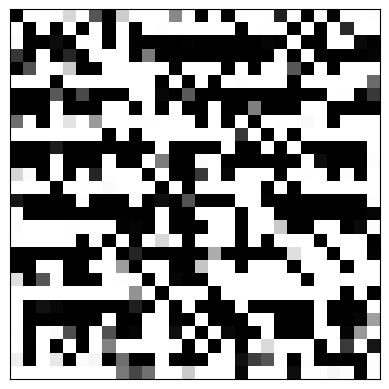

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


  1%|          | 1/94 [00:00<01:01,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


  2%|▏         | 2/94 [00:01<00:59,  1.53it/s]

2/2 [==============================] - 0s 6ms/step


  3%|▎         | 3/94 [00:01<00:58,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


  4%|▍         | 4/94 [00:02<00:57,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


  5%|▌         | 5/94 [00:03<01:09,  1.27it/s]

2/2 [==============================] - 0s 6ms/step


  6%|▋         | 6/94 [00:04<01:04,  1.36it/s]

2/2 [==============================] - 0s 6ms/step


  7%|▋         | 7/94 [00:04<01:03,  1.37it/s]

2/2 [==============================] - 0s 4ms/step


  9%|▊         | 8/94 [00:05<01:07,  1.27it/s]

2/2 [==============================] - 0s 6ms/step


 10%|▉         | 9/94 [00:06<01:10,  1.20it/s]

2/2 [==============================] - 0s 4ms/step


 11%|█         | 10/94 [00:07<01:09,  1.20it/s]

2/2 [==============================] - 0s 6ms/step


 12%|█▏        | 11/94 [00:08<01:04,  1.29it/s]

2/2 [==============================] - 0s 9ms/step


 13%|█▎        | 12/94 [00:08<00:59,  1.37it/s]

2/2 [==============================] - 0s 6ms/step


 14%|█▍        | 13/94 [00:09<00:57,  1.41it/s]

2/2 [==============================] - 0s 5ms/step


 15%|█▍        | 14/94 [00:10<00:54,  1.47it/s]

2/2 [==============================] - 0s 5ms/step


 16%|█▌        | 15/94 [00:10<00:52,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


 17%|█▋        | 16/94 [00:11<00:51,  1.53it/s]

2/2 [==============================] - 0s 4ms/step


 18%|█▊        | 17/94 [00:12<00:49,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 19%|█▉        | 18/94 [00:12<00:48,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 20%|██        | 19/94 [00:13<00:48,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 21%|██▏       | 20/94 [00:13<00:47,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 22%|██▏       | 21/94 [00:14<00:46,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 23%|██▎       | 22/94 [00:15<00:45,  1.59it/s]

2/2 [==============================] - 0s 6ms/step


 24%|██▍       | 23/94 [00:15<00:45,  1.57it/s]

2/2 [==============================] - 0s 7ms/step


 26%|██▌       | 24/94 [00:16<00:44,  1.58it/s]

2/2 [==============================] - 0s 4ms/step


 27%|██▋       | 25/94 [00:17<00:43,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 28%|██▊       | 26/94 [00:17<00:45,  1.49it/s]

2/2 [==============================] - 0s 9ms/step


 29%|██▊       | 27/94 [00:18<00:50,  1.33it/s]

2/2 [==============================] - 0s 4ms/step


 30%|██▉       | 28/94 [00:19<00:53,  1.25it/s]

2/2 [==============================] - 0s 4ms/step


 31%|███       | 29/94 [00:20<00:52,  1.24it/s]

2/2 [==============================] - 0s 5ms/step


 32%|███▏      | 30/94 [00:21<00:48,  1.33it/s]

2/2 [==============================] - 0s 6ms/step


 33%|███▎      | 31/94 [00:21<00:45,  1.40it/s]

2/2 [==============================] - 0s 5ms/step


 34%|███▍      | 32/94 [00:22<00:42,  1.46it/s]

2/2 [==============================] - 0s 5ms/step


 35%|███▌      | 33/94 [00:23<00:40,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


 36%|███▌      | 34/94 [00:23<00:39,  1.51it/s]

2/2 [==============================] - 0s 6ms/step


 37%|███▋      | 35/94 [00:24<00:39,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


 38%|███▊      | 36/94 [00:25<00:37,  1.53it/s]

2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 37/94 [00:25<00:36,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 40%|████      | 38/94 [00:26<00:35,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 41%|████▏     | 39/94 [00:26<00:35,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 43%|████▎     | 40/94 [00:27<00:34,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 44%|████▎     | 41/94 [00:28<00:33,  1.58it/s]

2/2 [==============================] - 0s 6ms/step


 45%|████▍     | 42/94 [00:28<00:32,  1.59it/s]

2/2 [==============================] - 0s 13ms/step


 46%|████▌     | 43/94 [00:29<00:32,  1.56it/s]

2/2 [==============================] - 0s 4ms/step


 47%|████▋     | 44/94 [00:30<00:31,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 48%|████▊     | 45/94 [00:30<00:34,  1.43it/s]

2/2 [==============================] - 0s 8ms/step


 49%|████▉     | 46/94 [00:34<01:15,  1.58s/it]

2/2 [==============================] - 0s 5ms/step


 50%|█████     | 47/94 [00:35<01:01,  1.30s/it]

2/2 [==============================] - 0s 5ms/step


 51%|█████     | 48/94 [00:35<00:50,  1.11s/it]

2/2 [==============================] - 0s 4ms/step


 52%|█████▏    | 49/94 [00:36<00:43,  1.02it/s]

2/2 [==============================] - 0s 5ms/step


 53%|█████▎    | 50/94 [00:37<00:38,  1.15it/s]

2/2 [==============================] - 0s 4ms/step


 54%|█████▍    | 51/94 [00:37<00:34,  1.25it/s]

2/2 [==============================] - 0s 4ms/step


 55%|█████▌    | 52/94 [00:38<00:31,  1.33it/s]

2/2 [==============================] - 0s 4ms/step


 56%|█████▋    | 53/94 [00:39<00:29,  1.39it/s]

2/2 [==============================] - 0s 5ms/step


 57%|█████▋    | 54/94 [00:39<00:28,  1.42it/s]

2/2 [==============================] - 0s 5ms/step


 59%|█████▊    | 55/94 [00:40<00:26,  1.46it/s]

2/2 [==============================] - 0s 6ms/step


 60%|█████▉    | 56/94 [00:41<00:25,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


 61%|██████    | 57/94 [00:41<00:24,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


 62%|██████▏   | 58/94 [00:42<00:23,  1.51it/s]

2/2 [==============================] - 0s 6ms/step


 63%|██████▎   | 59/94 [00:42<00:22,  1.52it/s]

2/2 [==============================] - 0s 9ms/step


 64%|██████▍   | 60/94 [00:43<00:25,  1.35it/s]

2/2 [==============================] - 0s 4ms/step


 65%|██████▍   | 61/94 [00:44<00:26,  1.26it/s]

2/2 [==============================] - 0s 4ms/step


 66%|██████▌   | 62/94 [00:45<00:26,  1.20it/s]

2/2 [==============================] - 0s 4ms/step


 67%|██████▋   | 63/94 [00:46<00:23,  1.30it/s]

2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 64/94 [00:47<00:21,  1.38it/s]

2/2 [==============================] - 0s 5ms/step


 69%|██████▉   | 65/94 [00:47<00:20,  1.43it/s]

2/2 [==============================] - 0s 4ms/step


 70%|███████   | 66/94 [00:48<00:18,  1.48it/s]

2/2 [==============================] - 0s 4ms/step


 71%|███████▏  | 67/94 [00:48<00:17,  1.51it/s]

2/2 [==============================] - 0s 6ms/step


 72%|███████▏  | 68/94 [00:49<00:17,  1.52it/s]

2/2 [==============================] - 0s 4ms/step


 73%|███████▎  | 69/94 [00:50<00:16,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 74%|███████▍  | 70/94 [00:50<00:15,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 76%|███████▌  | 71/94 [00:51<00:17,  1.35it/s]

2/2 [==============================] - 0s 14ms/step


 77%|███████▋  | 72/94 [00:52<00:17,  1.24it/s]

2/2 [==============================] - 0s 4ms/step


 78%|███████▊  | 73/94 [00:53<00:15,  1.33it/s]

2/2 [==============================] - 0s 5ms/step


 79%|███████▊  | 74/94 [00:53<00:14,  1.40it/s]

2/2 [==============================] - 0s 5ms/step


 80%|███████▉  | 75/94 [00:54<00:13,  1.44it/s]

2/2 [==============================] - 0s 5ms/step


 81%|████████  | 76/94 [00:55<00:12,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 77/94 [00:56<00:11,  1.42it/s]

2/2 [==============================] - 0s 4ms/step


 83%|████████▎ | 78/94 [00:56<00:12,  1.31it/s]

2/2 [==============================] - 0s 4ms/step


 84%|████████▍ | 79/94 [00:57<00:12,  1.23it/s]

2/2 [==============================] - 0s 5ms/step


 85%|████████▌ | 80/94 [00:58<00:11,  1.24it/s]

2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 81/94 [00:59<00:09,  1.33it/s]

2/2 [==============================] - 0s 5ms/step


 87%|████████▋ | 82/94 [00:59<00:08,  1.40it/s]

2/2 [==============================] - 0s 5ms/step


 88%|████████▊ | 83/94 [01:00<00:07,  1.46it/s]

2/2 [==============================] - 0s 6ms/step


 89%|████████▉ | 84/94 [01:01<00:06,  1.47it/s]

2/2 [==============================] - 0s 6ms/step


 90%|█████████ | 85/94 [01:01<00:06,  1.50it/s]

2/2 [==============================] - 0s 6ms/step


 91%|█████████▏| 86/94 [01:02<00:05,  1.53it/s]

2/2 [==============================] - 0s 5ms/step


 93%|█████████▎| 87/94 [01:03<00:04,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 94%|█████████▎| 88/94 [01:03<00:03,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 95%|█████████▍| 89/94 [01:04<00:03,  1.57it/s]

2/2 [==============================] - 0s 4ms/step


 96%|█████████▌| 90/94 [01:04<00:02,  1.58it/s]

2/2 [==============================] - 0s 6ms/step


 97%|█████████▋| 91/94 [01:05<00:01,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 98%|█████████▊| 92/94 [01:06<00:01,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 99%|█████████▉| 93/94 [01:06<00:00,  1.59it/s]

2/2 [==============================] - 0s 4ms/step


100%|██████████| 94/94 [01:07<00:00,  1.39it/s]

Epoch: 8/10 	 Discriminator Loss: 0.921 Generator Loss: 0.921
1/1 [==============================] - 0s 19ms/step


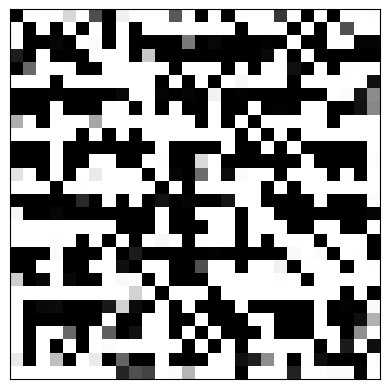

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


  1%|          | 1/94 [00:00<01:01,  1.52it/s]

2/2 [==============================] - 0s 4ms/step


  2%|▏         | 2/94 [00:01<01:11,  1.29it/s]

2/2 [==============================] - 0s 4ms/step


  3%|▎         | 3/94 [00:02<01:16,  1.19it/s]

2/2 [==============================] - 0s 4ms/step


  4%|▍         | 4/94 [00:03<01:19,  1.14it/s]

2/2 [==============================] - 0s 5ms/step


  5%|▌         | 5/94 [00:04<01:12,  1.22it/s]

2/2 [==============================] - 0s 7ms/step


  6%|▋         | 6/94 [00:04<01:06,  1.33it/s]

2/2 [==============================] - 0s 5ms/step


  7%|▋         | 7/94 [00:05<01:01,  1.41it/s]

2/2 [==============================] - 0s 6ms/step


  9%|▊         | 8/94 [00:05<00:58,  1.46it/s]

2/2 [==============================] - 0s 5ms/step


 10%|▉         | 9/94 [00:06<00:56,  1.49it/s]

2/2 [==============================] - 0s 4ms/step


 11%|█         | 10/94 [00:07<00:55,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 12%|█▏        | 11/94 [00:07<00:53,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 13%|█▎        | 12/94 [00:08<00:52,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 14%|█▍        | 13/94 [00:09<00:51,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 15%|█▍        | 14/94 [00:09<00:50,  1.57it/s]

2/2 [==============================] - 0s 8ms/step


 16%|█▌        | 15/94 [00:10<00:49,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 17%|█▋        | 16/94 [00:11<00:49,  1.57it/s]

2/2 [==============================] - 0s 4ms/step


 18%|█▊        | 17/94 [00:11<00:48,  1.58it/s]

2/2 [==============================] - 0s 4ms/step


 19%|█▉        | 18/94 [00:12<00:47,  1.59it/s]

2/2 [==============================] - 0s 4ms/step


 20%|██        | 19/94 [00:12<00:47,  1.58it/s]

2/2 [==============================] - 0s 6ms/step


 21%|██▏       | 20/94 [00:13<00:46,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 22%|██▏       | 21/94 [00:14<00:52,  1.39it/s]

2/2 [==============================] - 0s 4ms/step


 23%|██▎       | 22/94 [00:15<00:56,  1.28it/s]

2/2 [==============================] - 0s 4ms/step


 24%|██▍       | 23/94 [00:16<00:57,  1.23it/s]

2/2 [==============================] - 0s 8ms/step


 26%|██▌       | 24/94 [00:16<00:53,  1.30it/s]

2/2 [==============================] - 0s 5ms/step


 27%|██▋       | 25/94 [00:17<00:50,  1.38it/s]

2/2 [==============================] - 0s 5ms/step


 28%|██▊       | 26/94 [00:18<00:47,  1.43it/s]

2/2 [==============================] - 0s 5ms/step


 29%|██▊       | 27/94 [00:18<00:45,  1.48it/s]

2/2 [==============================] - 0s 6ms/step


 30%|██▉       | 28/94 [00:19<00:44,  1.50it/s]

2/2 [==============================] - 0s 6ms/step


 31%|███       | 29/94 [00:20<00:43,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


 32%|███▏      | 30/94 [00:20<00:41,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 33%|███▎      | 31/94 [00:21<00:40,  1.56it/s]

2/2 [==============================] - 0s 6ms/step


 34%|███▍      | 32/94 [00:21<00:39,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 35%|███▌      | 33/94 [00:22<00:38,  1.58it/s]

2/2 [==============================] - 0s 4ms/step


 36%|███▌      | 34/94 [00:23<00:37,  1.58it/s]

2/2 [==============================] - 0s 6ms/step


 37%|███▋      | 35/94 [00:23<00:37,  1.55it/s]

2/2 [==============================] - 0s 4ms/step


 38%|███▊      | 36/94 [00:24<00:37,  1.56it/s]

2/2 [==============================] - 0s 4ms/step


 39%|███▉      | 37/94 [00:25<00:36,  1.56it/s]

2/2 [==============================] - 0s 4ms/step


 40%|████      | 38/94 [00:25<00:35,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 41%|████▏     | 39/94 [00:26<00:36,  1.52it/s]

2/2 [==============================] - 0s 5ms/step


 43%|████▎     | 40/94 [00:27<00:39,  1.36it/s]

2/2 [==============================] - 0s 4ms/step


 44%|████▎     | 41/94 [00:28<00:42,  1.26it/s]

2/2 [==============================] - 0s 4ms/step


 45%|████▍     | 42/94 [00:29<00:42,  1.22it/s]

2/2 [==============================] - 0s 5ms/step


 46%|████▌     | 43/94 [00:29<00:39,  1.29it/s]

2/2 [==============================] - 0s 5ms/step


 47%|████▋     | 44/94 [00:30<00:36,  1.36it/s]

2/2 [==============================] - 0s 5ms/step


 48%|████▊     | 45/94 [00:31<00:34,  1.43it/s]

2/2 [==============================] - 0s 5ms/step


 49%|████▉     | 46/94 [00:31<00:32,  1.46it/s]

2/2 [==============================] - 0s 5ms/step


 50%|█████     | 47/94 [00:32<00:31,  1.49it/s]

2/2 [==============================] - 0s 5ms/step


 51%|█████     | 48/94 [00:33<00:30,  1.51it/s]

2/2 [==============================] - 0s 6ms/step


 52%|█████▏    | 49/94 [00:33<00:29,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 53%|█████▎    | 50/94 [00:34<00:28,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 54%|█████▍    | 51/94 [00:34<00:27,  1.58it/s]

2/2 [==============================] - 0s 4ms/step


 55%|█████▌    | 52/94 [00:35<00:26,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 56%|█████▋    | 53/94 [00:36<00:26,  1.57it/s]

2/2 [==============================] - 0s 8ms/step


 57%|█████▋    | 54/94 [00:36<00:25,  1.57it/s]

2/2 [==============================] - 0s 4ms/step


 59%|█████▊    | 55/94 [00:37<00:24,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 60%|█████▉    | 56/94 [00:38<00:24,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 61%|██████    | 57/94 [00:38<00:23,  1.58it/s]

2/2 [==============================] - 0s 6ms/step


 62%|██████▏   | 58/94 [00:39<00:24,  1.47it/s]

2/2 [==============================] - 0s 12ms/step


 63%|██████▎   | 59/94 [00:40<00:26,  1.34it/s]

2/2 [==============================] - 0s 7ms/step


 64%|██████▍   | 60/94 [00:41<00:27,  1.25it/s]

2/2 [==============================] - 0s 4ms/step


 65%|██████▍   | 61/94 [00:42<00:26,  1.25it/s]

2/2 [==============================] - 0s 4ms/step


 66%|██████▌   | 62/94 [00:42<00:23,  1.33it/s]

2/2 [==============================] - 0s 5ms/step


 67%|██████▋   | 63/94 [00:43<00:22,  1.40it/s]

2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 64/94 [00:44<00:20,  1.44it/s]

2/2 [==============================] - 0s 5ms/step


 69%|██████▉   | 65/94 [00:44<00:19,  1.48it/s]

2/2 [==============================] - 0s 5ms/step


 70%|███████   | 66/94 [00:45<00:18,  1.51it/s]

2/2 [==============================] - 0s 4ms/step


 71%|███████▏  | 67/94 [00:46<00:17,  1.51it/s]

2/2 [==============================] - 0s 6ms/step


 72%|███████▏  | 68/94 [00:46<00:16,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 73%|███████▎  | 69/94 [00:47<00:16,  1.54it/s]

2/2 [==============================] - 0s 6ms/step


 74%|███████▍  | 70/94 [00:47<00:15,  1.56it/s]

2/2 [==============================] - 0s 6ms/step


 76%|███████▌  | 71/94 [00:48<00:14,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 77%|███████▋  | 72/94 [00:49<00:14,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 78%|███████▊  | 73/94 [00:49<00:13,  1.58it/s]

2/2 [==============================] - 0s 11ms/step


 79%|███████▊  | 74/94 [00:51<00:17,  1.14it/s]

2/2 [==============================] - 0s 15ms/step


 80%|███████▉  | 75/94 [00:53<00:22,  1.17s/it]

2/2 [==============================] - 0s 6ms/step


 81%|████████  | 76/94 [00:55<00:27,  1.55s/it]

2/2 [==============================] - 0s 12ms/step


 82%|████████▏ | 77/94 [00:56<00:23,  1.37s/it]

2/2 [==============================] - 0s 5ms/step


 83%|████████▎ | 78/94 [00:57<00:19,  1.23s/it]

2/2 [==============================] - 0s 5ms/step


 84%|████████▍ | 79/94 [00:58<00:17,  1.19s/it]

2/2 [==============================] - 0s 6ms/step


 85%|████████▌ | 80/94 [00:59<00:14,  1.06s/it]

2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 81/94 [01:00<00:12,  1.02it/s]

2/2 [==============================] - 0s 5ms/step


 87%|████████▋ | 82/94 [01:00<00:11,  1.09it/s]

2/2 [==============================] - 0s 14ms/step


 88%|████████▊ | 83/94 [01:01<00:10,  1.04it/s]

2/2 [==============================] - 0s 5ms/step


 89%|████████▉ | 84/94 [01:02<00:09,  1.09it/s]

2/2 [==============================] - 0s 5ms/step


 90%|█████████ | 85/94 [01:03<00:07,  1.13it/s]

2/2 [==============================] - 0s 6ms/step


 91%|█████████▏| 86/94 [01:04<00:07,  1.11it/s]

2/2 [==============================] - 0s 14ms/step


 93%|█████████▎| 87/94 [01:05<00:06,  1.15it/s]

2/2 [==============================] - 0s 5ms/step


 94%|█████████▎| 88/94 [01:06<00:05,  1.07it/s]

2/2 [==============================] - 0s 21ms/step


 95%|█████████▍| 89/94 [01:08<00:06,  1.21s/it]

2/2 [==============================] - 0s 14ms/step


 96%|█████████▌| 90/94 [01:09<00:04,  1.15s/it]

2/2 [==============================] - 0s 5ms/step


 97%|█████████▋| 91/94 [01:09<00:02,  1.01it/s]

2/2 [==============================] - 0s 4ms/step


 98%|█████████▊| 92/94 [01:10<00:01,  1.14it/s]

2/2 [==============================] - 0s 5ms/step


 99%|█████████▉| 93/94 [01:11<00:00,  1.22it/s]

2/2 [==============================] - 0s 4ms/step


100%|██████████| 94/94 [01:11<00:00,  1.31it/s]

Epoch: 9/10 	 Discriminator Loss: 0.928 Generator Loss: 0.928
1/1 [==============================] - 0s 16ms/step


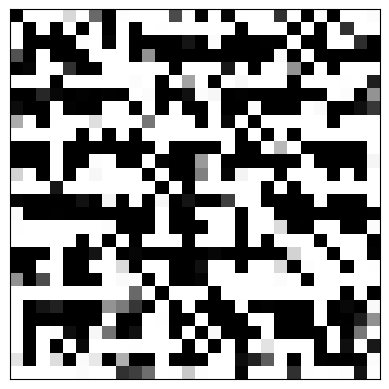

  0%|          | 0/94 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


  1%|          | 1/94 [00:00<01:00,  1.54it/s]

2/2 [==============================] - 0s 4ms/step


  2%|▏         | 2/94 [00:01<00:58,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


  3%|▎         | 3/94 [00:01<00:56,  1.60it/s]

2/2 [==============================] - 0s 5ms/step


  4%|▍         | 4/94 [00:02<00:56,  1.60it/s]

2/2 [==============================] - 0s 5ms/step


  5%|▌         | 5/94 [00:03<00:56,  1.59it/s]

2/2 [==============================] - 0s 6ms/step


  6%|▋         | 6/94 [00:03<00:55,  1.60it/s]

2/2 [==============================] - 0s 4ms/step


  7%|▋         | 7/94 [00:04<00:54,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


  9%|▊         | 8/94 [00:05<00:54,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 10%|▉         | 9/94 [00:05<00:53,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 11%|█         | 10/94 [00:06<00:53,  1.57it/s]

2/2 [==============================] - 0s 4ms/step


 12%|█▏        | 11/94 [00:06<00:53,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 13%|█▎        | 12/94 [00:07<01:00,  1.36it/s]

2/2 [==============================] - 0s 8ms/step


 14%|█▍        | 13/94 [00:08<01:04,  1.26it/s]

2/2 [==============================] - 0s 4ms/step


 15%|█▍        | 14/94 [00:09<01:06,  1.20it/s]

2/2 [==============================] - 0s 6ms/step


 16%|█▌        | 15/94 [00:10<01:01,  1.29it/s]

2/2 [==============================] - 0s 6ms/step


 17%|█▋        | 16/94 [00:11<00:56,  1.38it/s]

2/2 [==============================] - 0s 5ms/step


 18%|█▊        | 17/94 [00:11<00:54,  1.42it/s]

2/2 [==============================] - 0s 5ms/step


 19%|█▉        | 18/94 [00:12<00:52,  1.45it/s]

2/2 [==============================] - 0s 6ms/step


 20%|██        | 19/94 [00:13<00:51,  1.46it/s]

2/2 [==============================] - 0s 5ms/step


 21%|██▏       | 20/94 [00:13<00:49,  1.50it/s]

2/2 [==============================] - 0s 5ms/step


 22%|██▏       | 21/94 [00:14<00:47,  1.53it/s]

2/2 [==============================] - 0s 9ms/step


 23%|██▎       | 22/94 [00:14<00:46,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 24%|██▍       | 23/94 [00:15<00:45,  1.56it/s]

2/2 [==============================] - 0s 4ms/step


 26%|██▌       | 24/94 [00:16<00:45,  1.55it/s]

2/2 [==============================] - 0s 6ms/step


 27%|██▋       | 25/94 [00:16<00:44,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 28%|██▊       | 26/94 [00:17<00:43,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 29%|██▊       | 27/94 [00:18<00:42,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 30%|██▉       | 28/94 [00:18<00:41,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 31%|███       | 29/94 [00:19<00:40,  1.59it/s]

2/2 [==============================] - 0s 6ms/step


 32%|███▏      | 30/94 [00:20<00:42,  1.50it/s]

2/2 [==============================] - 0s 17ms/step


 33%|███▎      | 31/94 [00:21<00:47,  1.32it/s]

2/2 [==============================] - 0s 6ms/step


 34%|███▍      | 32/94 [00:21<00:50,  1.24it/s]

2/2 [==============================] - 0s 8ms/step


 35%|███▌      | 33/94 [00:22<00:49,  1.24it/s]

2/2 [==============================] - 0s 5ms/step


 36%|███▌      | 34/94 [00:23<00:45,  1.33it/s]

2/2 [==============================] - 0s 5ms/step


 37%|███▋      | 35/94 [00:24<00:42,  1.39it/s]

2/2 [==============================] - 0s 5ms/step


 38%|███▊      | 36/94 [00:24<00:39,  1.46it/s]

2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 37/94 [00:25<00:38,  1.50it/s]

2/2 [==============================] - 0s 5ms/step


 40%|████      | 38/94 [00:25<00:36,  1.52it/s]

2/2 [==============================] - 0s 6ms/step


 41%|████▏     | 39/94 [00:26<00:36,  1.52it/s]

2/2 [==============================] - 0s 4ms/step


 43%|████▎     | 40/94 [00:27<00:35,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 44%|████▎     | 41/94 [00:27<00:34,  1.53it/s]

2/2 [==============================] - 0s 4ms/step


 45%|████▍     | 42/94 [00:28<00:33,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 46%|████▌     | 43/94 [00:29<00:32,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 47%|████▋     | 44/94 [00:29<00:32,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 48%|████▊     | 45/94 [00:30<00:31,  1.55it/s]

2/2 [==============================] - 0s 6ms/step


 49%|████▉     | 46/94 [00:31<00:31,  1.55it/s]

2/2 [==============================] - 0s 5ms/step


 50%|█████     | 47/94 [00:31<00:29,  1.57it/s]

2/2 [==============================] - 0s 4ms/step


 51%|█████     | 48/94 [00:32<00:29,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 52%|█████▏    | 49/94 [00:33<00:31,  1.43it/s]

2/2 [==============================] - 0s 9ms/step


 53%|█████▎    | 50/94 [00:34<00:33,  1.31it/s]

2/2 [==============================] - 0s 4ms/step


 54%|█████▍    | 51/94 [00:34<00:34,  1.24it/s]

2/2 [==============================] - 0s 4ms/step


 55%|█████▌    | 52/94 [00:35<00:32,  1.29it/s]

2/2 [==============================] - 0s 5ms/step


 56%|█████▋    | 53/94 [00:36<00:30,  1.36it/s]

2/2 [==============================] - 0s 4ms/step


 57%|█████▋    | 54/94 [00:36<00:27,  1.43it/s]

2/2 [==============================] - 0s 5ms/step


 59%|█████▊    | 55/94 [00:37<00:26,  1.48it/s]

2/2 [==============================] - 0s 4ms/step


 60%|█████▉    | 56/94 [00:38<00:25,  1.51it/s]

2/2 [==============================] - 0s 5ms/step


 61%|██████    | 57/94 [00:38<00:23,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 62%|██████▏   | 58/94 [00:39<00:23,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 63%|██████▎   | 59/94 [00:40<00:22,  1.56it/s]

2/2 [==============================] - 0s 6ms/step


 64%|██████▍   | 60/94 [00:40<00:21,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 65%|██████▍   | 61/94 [00:41<00:20,  1.58it/s]

2/2 [==============================] - 0s 4ms/step


 66%|██████▌   | 62/94 [00:41<00:20,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 67%|██████▋   | 63/94 [00:42<00:19,  1.59it/s]

2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 64/94 [00:43<00:19,  1.56it/s]

2/2 [==============================] - 0s 5ms/step


 69%|██████▉   | 65/94 [00:43<00:18,  1.54it/s]

2/2 [==============================] - 0s 5ms/step


 70%|███████   | 66/94 [00:44<00:18,  1.52it/s]

2/2 [==============================] - 0s 4ms/step


 71%|███████▏  | 67/94 [00:45<00:17,  1.55it/s]

2/2 [==============================] - 0s 10ms/step


 72%|███████▏  | 68/94 [00:46<00:18,  1.38it/s]

2/2 [==============================] - 0s 4ms/step


 73%|███████▎  | 69/94 [00:47<00:19,  1.27it/s]

2/2 [==============================] - 0s 4ms/step


 74%|███████▍  | 70/94 [00:47<00:19,  1.22it/s]

2/2 [==============================] - 0s 6ms/step


 76%|███████▌  | 71/94 [00:48<00:18,  1.28it/s]

2/2 [==============================] - 0s 5ms/step


 77%|███████▋  | 72/94 [00:49<00:16,  1.35it/s]

2/2 [==============================] - 0s 5ms/step


 78%|███████▊  | 73/94 [00:49<00:14,  1.41it/s]

2/2 [==============================] - 0s 5ms/step


 79%|███████▊  | 74/94 [00:50<00:13,  1.46it/s]

2/2 [==============================] - 0s 4ms/step


 80%|███████▉  | 75/94 [00:51<00:12,  1.47it/s]

2/2 [==============================] - 0s 4ms/step


 81%|████████  | 76/94 [00:51<00:11,  1.51it/s]

2/2 [==============================] - 0s 6ms/step


 82%|████████▏ | 77/94 [00:52<00:11,  1.53it/s]

2/2 [==============================] - 0s 4ms/step


 83%|████████▎ | 78/94 [00:53<00:10,  1.54it/s]

2/2 [==============================] - 0s 7ms/step


 84%|████████▍ | 79/94 [00:53<00:09,  1.55it/s]

2/2 [==============================] - 0s 4ms/step


 85%|████████▌ | 80/94 [00:54<00:08,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 81/94 [00:54<00:08,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 87%|████████▋ | 82/94 [00:55<00:07,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 88%|████████▊ | 83/94 [00:56<00:06,  1.58it/s]

2/2 [==============================] - 0s 5ms/step


 89%|████████▉ | 84/94 [00:56<00:06,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 90%|█████████ | 85/94 [00:57<00:05,  1.57it/s]

2/2 [==============================] - 0s 5ms/step


 91%|█████████▏| 86/94 [00:58<00:05,  1.55it/s]

2/2 [==============================] - 0s 6ms/step


 93%|█████████▎| 87/94 [00:59<00:05,  1.36it/s]

2/2 [==============================] - 0s 13ms/step


 94%|█████████▎| 88/94 [01:00<00:05,  1.19it/s]

2/2 [==============================] - 0s 4ms/step


 95%|█████████▍| 89/94 [01:01<00:04,  1.16it/s]

2/2 [==============================] - 0s 5ms/step


 96%|█████████▌| 90/94 [01:01<00:03,  1.27it/s]

2/2 [==============================] - 0s 5ms/step


 97%|█████████▋| 91/94 [01:02<00:02,  1.35it/s]

2/2 [==============================] - 0s 6ms/step


 98%|█████████▊| 92/94 [01:05<00:03,  1.60s/it]

2/2 [==============================] - 0s 5ms/step


 99%|█████████▉| 93/94 [01:06<00:01,  1.32s/it]

2/2 [==============================] - 0s 6ms/step


100%|██████████| 94/94 [01:07<00:00,  1.40it/s]

Epoch: 10/10 	 Discriminator Loss: 0.924 Generator Loss: 0.924
1/1 [==============================] - 0s 17ms/step


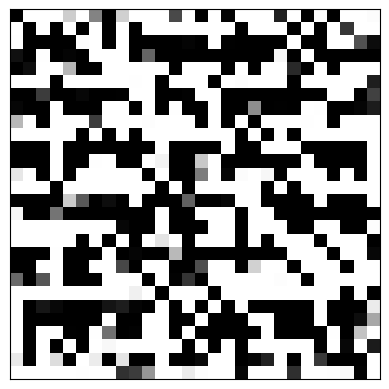

In [ ]:
# Train
from tqdm import tqdm

for epoch in range(epochs):
  for batch in tqdm(range(steps_per_epoch)):
    # สร้าง Random noise เพื่อใช้เป็นอินพุตให้กับ Generator
    noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
    fake_x = generator.predict(noise)     # สร้างภาพ fake

    # สร้างชุดข้อมูลจริง (ข้อมูลจาก x_train) โดยแบ่งสุ่มมา
    real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
    x = np.concatenate((real_x, fake_x))    # นำ fake และจริง มาต่อกัน

    disc_y = np.zeros(2*batch_size)   # label สำหรับ Discriminator
    disc_y[:batch_size] = 0.9

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)    # compile ใหม่ทุกรอบ
    d_loss = discriminator.train_on_batch(x, disc_y)    # Train Discriminator

    y_gen = np.ones(batch_size)     # สร้างค่า y=1 สำหรับ Generator
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)    # compile ใหม่ทุกรอบ
    g_loss = gan.train_on_batch(noise, y_gen)     # Train Generator

  print(f'Epoch: {epoch+1}/{epochs} \t Discriminator Loss: {d_loss:.3f} Generator Loss: {d_loss:.3f}')

  ## แสดงภาพจาก Generator 3 แถว 5 คอลัมน์ โดยส่ง Noise เป็นอินพุตเข้า Generator
  # dsp_img = (3, 5)
  # noise = np.random.normal(0, 1, size=(dsp_img[0], dsp_img[1], noise_dim))
  # show_images(noise, dsp_img)
  noise = np.random.normal(0, 1, size=(1, noise_dim))     # สร้างค่า random (มิติ 100)
  image = generator.predict(noise)   # Generator สร้างภาพ image จาก noise
  plt.xticks([]); plt.yticks([])
  plt.imshow(image.reshape((img_rows, img_cols)), cmap=plt.cm.gray_r)   # พล็อต
  plt.show()

จะเห็นว่าภาพ fake ใน epoch แรกๆค่อนข้างเลือนลาง แต่ epoch ท้ายๆ(ประมาณ 100 epochs)จะชัดเจนเหมือนจริงมากขึ้น

# (2.) GAN สร้างภาพ Celeb

สร้างภาพใบหน้า Celeb โดย dataset ที่ใช้ประกอบด้วยภาพหน้า Celeb แสนภาพ ขนากไฟล์รวม 1.3 GB การ Train บน Colab GPU ใช้ 1 ชม. ต่อ Epoch

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

สร้างโฟลเดอร์ ดาวน์โหลด zip แล้ว unzip ใส่ไว้ในโฟลเดอร์ที่เตียมไว้ โดยทุกภาพอยู่ในโฟลเดอร์เดียวกัน

In [ ]:
os.makedirs("celeba_gan")    # create folder

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)     # download

with ZipFile("celeba_gan/data.zip", "r") as zipobj:   # unzip
  zipobj.extractall("celeba_gan")

อ่านข้อมูลไฟล์ภาพมาเก็บไว้ใน dataset โดยกำหนดขนาดภาพ 64x64 batch_size=32 จากนั้นทำ Normalize และเนื่องจากภาพอยู่ใยโฟลเดอร์เดียวกันหมด จึงทำให้ dataset มีคลาสเดียวเท่านั้น แต่ไม่มีปัญหา เนื่องจาก GAN ไม่ได้ใช้ Label หรือคลาสอยู่แล้ว

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


พล็อตดูหลายภาพ

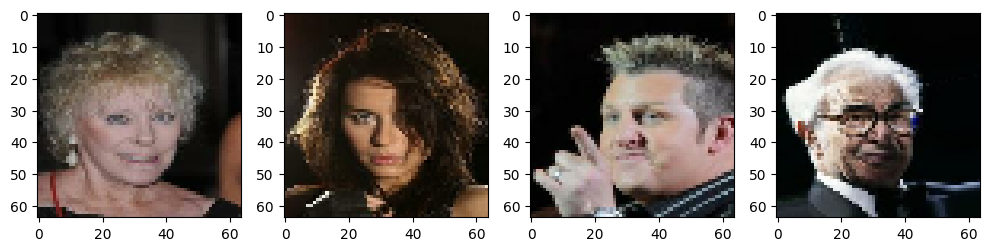

In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize=(10, 10))
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

iterator = iter(dataset)
img_samples = next(iterator)[:4]
plotImages(img_samples)

## สร้าง model

การสร้างโมเดลสำหรับ GAN ให้สร้าง Generator และ Discriminitor จากนั้นจึงนำ 2 ส่วนนี้มาประกอบกันเป็น GAN

เริ่มสร้าง Discriminator ให้ชั้นสุดท้ายมี 1 Node สำหรับเอาต์พุตค่า Score ระหว่าง 0 1 เพื่อตัดสินว่าภาพที่ Generator สร้างขึ้นมา fake หรือ real ส่วนอินพุตเท่ากับมิติภาพ Dataset คือ 64x64x3 channel 3 สี

สรุปชั้น Discriminator มีดังนี้ 64x64x3 -> 32x32x64 -> 16x16x128 -> 8x8x128 -> 8192 -> 1

In [ ]:
# สร้าง Model Discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),    # 64x64x3
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

เตรียมฟังก์ชันสำหรับสร้าง Generator หลักการเหมือนเดิม คือพิจารณาโครงสร้างจาก Layer ท้ายมาก่อน โดยในที่นี้ต้องการข้อมูลภาพมิติ 64x64x3 (ต้องการสร้างภาพ fake เลียนแบบต้นฉบับใน dataset) อินพุตกำหนดให้มีขนาดเริ่มต้น 128 (latent_dim หรือขนาด Noise) เมื่อขยายไปถึงท้ายๆ จะได้ขนาด 64x64x3 ดังนั้น ชั้นและขนาด Generator เป็นดังนี้ (8192 ได้จาก 8x8x128)

128 -> 8192 -> 8x8x128 -> 16x16x128 -> 32x32x256 -> 64x64x512 -> 64x64x3

In [ ]:
# สร้าง Model Generator
# ลักษณะคือพับ Discriminator กลับแบบกระจกเงา แทนที่ Conv2D layers ด้วย Conv2DTranspose layers

latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 *128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid'),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

สร้าง Class สำหรับ GAN

In [ ]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).__init__()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    # ค่าสุ่มสำหรับ latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # สร้างภาพ fake ( ถอดรหัส Decode)
    generated_images = self.generator(random_latent_vectors)

    # รวมข้อมูลภาพ (ภาพ fake และ จริง)
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # สร้าง Labels dicriminating real จากภาพ fake
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )

    # ใส่ค่าสุ่ม random noise ลงใน labels
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # Train discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    # ค่าสุ่มสำหรับ Latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # สร้าง Label ที่บอกว่า นี่คือภาพจริง (real images)
    misleading_labels = tf.zeros((batch_size, 1))

    # Train generator (ช่วงนี้ discriminator จะไม่ถูก Train ไม่ถูก updates weights)
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(grads, self.generator.trainable_weights)
    )

    # อัปเดตค่า Loss
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {
        "d_loss": self.d_loss_metric.result(),
        "g_loss": self.g_loss_metric.result()
    }

สร้าง Class สำหรับบันทึกภาพ fake เป็นไฟล์ png เป็นระยะๆ (Monitor) เอาไว้ดูว่า Generator สร้างภาพอย่างไรบ้าง

In [ ]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = keras.preprocessing.images.array_to_img(generated_images[i])
      img.save("generated_img_%03d_%d.png" % (epoch, i))

epochs = 1    # ตั้งค่าน้อย train น้อย

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

สั่ง Train

In [ ]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

เอ๋อ เลยยยย